In [61]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("..")
from src.nce.binary import NceBinaryCrit
from src.nce.cnce import CondNceCrit

from src.noise_distr.normal import MultivariateNormal
from src.noise_distr.conditional_normal import ConditionalMultivariateNormal

from src.models.ring_model.ring_model import RingModel, RingModelNCE, unnorm_ring_model_log_pdf
from src.data.ring_model_dataset import RingModelDataset

from src.training.model_training import train_model
from src.training.training_utils import PrecisionErrorMetric, no_change_stopping_condition

## EXPERIMENT HELP FUNCTIONS

In [62]:
# Noise distribution parameters, NCE

# Adapted from https://github.com/ciwanceylan/CNCE-matlab/blob/master/matlab/synthetic_data/bin/estimation/noise/continous/gNCEnoise.m
def get_nce_noise_distr_par(y):
    mu = torch.mean(y, dim=0)
    cov = torch.cov(torch.transpose(y, 0, 1))
    
    return mu, cov

In [63]:
# Noise distribution parameters, CNCE
# Adapted from https://github.com/ciwanceylan/CNCE-matlab/blob/master/matlab/synthetic_data/bin/estimation/noise/continous/gNoise.m

def get_cnce_epsilon_base(y):
    return torch.std(y, dim=-1).mean()

def get_cnce_covariance_matrix(epsilon_factor, epsilon_base, num_dims):
    return torch.eye(num_dims) * (epsilon_factor * epsilon_base)**2


# Adapted from https://github.com/ciwanceylan/CNCE-matlab/blob/master/matlab/synthetic_data/bin/estimation/noise/continous/gEpsilonBaseFun.m
def get_cnce_noise_distr_par(y, neg_sample_size, mu, log_precision):
    epsilon_factor = get_cnce_epsilon_factor(y, neg_sample_size, mu, log_precision)
    epsilon_base = get_cnce_epsilon_base(y)
    return get_cnce_covariance_matrix(epsilon_factor, epsilon_base, y.size(-1))


def evaluate_cnce_loss(epsilon_factor, neg_sample_size, p_m):
    
    epsilon_base = get_cnce_epsilon_base(y)
    cov_noise = get_cnce_covariance_matrix(epsilon_factor, epsilon_base, y.size(-1))
    
    p_n = ConditionalMultivariateNormal(cov=cov_noise)
    criterion = CondNceCrit(p_m, p_n)
    y_samples = criterion.sample_noise(neg_sample_size * y.size(0), y)
    
    return criterion.crit(y, y_samples)


def get_cnce_epsilon_factor(y, neg_sample_size, mu, log_precision, thrs_lower=0.05, thrs_upper=0.5, inc_rate=0.2, 
                            dec_rate=0.5, max_iter=500, eps_hard_cap=1000):
    
    loss_zero = np.log(2) # 2 * log(2)  # Loss as epsilon -> 0 
    loss_inf = 0  # Loss as epsilon -> inf
    thrs_upper = thrs_upper * loss_zero  
    
    num_dims = y.size(-1)
    p_m = RingModel(mu=mu, log_precision=log_precision)  
    
    epsilon_factor = 0.5  # Start value 

    # Calculate initial loss
    loss = evaluate_cnce_loss(epsilon_factor, neg_sample_size, p_m)

    # Iterate until conditions are met 
    k = 1;
    while (k < max_iter) and (abs(1 - (loss/loss_zero)) < thrs_lower or loss < thrs_upper ) and (epsilon_factor < eps_hard_cap):

        if abs(1 - (loss/loss_zero)) < thrs_lower: 
            epsilon_factor = (1 + inc_rate) * epsilon_factor
        elif loss < thrs_upper:
            epsilon_factor = (1 - dec_rate) * epsilon_factor
   
        loss = evaluate_cnce_loss(epsilon_factor, neg_sample_size, p_m)

        k = k + 1
    
    return epsilon_factor


In [80]:
# Generation of true parameters, parameter initialisation

# Adapted from https://github.com/ciwanceylan/CNCE-matlab/blob/master/matlab/synthetic_data/bin/data_generation/generate_parameters.m
def generate_true_params(mu_min=5, mu_max=10, sigma_min=0.3, sigma_max=1.5):
    mu = (mu_max - mu_min) * torch.rand(1) + mu_min
    sigma = (sigma_max - sigma_min) * torch.rand(1) + sigma_min
    precision = sigma**(-2)
    z = -0.5 * torch.log(2 * torch.tensor(np.pi)) - torch.log(sigma) 
    
    return mu, precision, z

def initialise_params(mu_min=6, mu_max=8, sigma_min=0.3, sigma_max=1.5, z_min = 0.01):
    mu = (mu_max - mu_min) * torch.rand(1) + mu_min
    sigma = (sigma_max - sigma_min) * torch.rand(1) + sigma_min
    precision = sigma**(-2)
    
    z = torch.rand(1) + z_min

    return mu, torch.log(precision), torch.log(z)


## NOISE DISTRIBUTIONS PLOT

In [81]:
# Some helper functions
def get_grid_data(y_min=-10, y_max=10, grid_size=100):
    ny = np.linspace(y_min, y_max, grid_size)
    Y1, Y2 = np.meshgrid(ny, ny)
    y_grid = torch.tensor(np.column_stack((Y1.reshape(-1), Y2.reshape(-1))))
    
    return y_grid


def sample_nce(y, num_samples):
    mu_noise_nce, cov_noise_nce = get_nce_noise_distr_par(y)

    p_n = MultivariateNormal(mu=mu_noise_nce, cov=cov_noise_nce)
    return p_n.sample(torch.Size((num_samples,)))


def sample_cnce(y, num_samples, mu, log_precision, neg_sample_size=10):
    cov_noise = get_cnce_noise_distr_par(y, neg_sample_size, mu, log_precision)
    
    p_n = ConditionalMultivariateNormal(cov=cov_noise)
    
    return p_n.sample(torch.Size((num_samples,)), y)


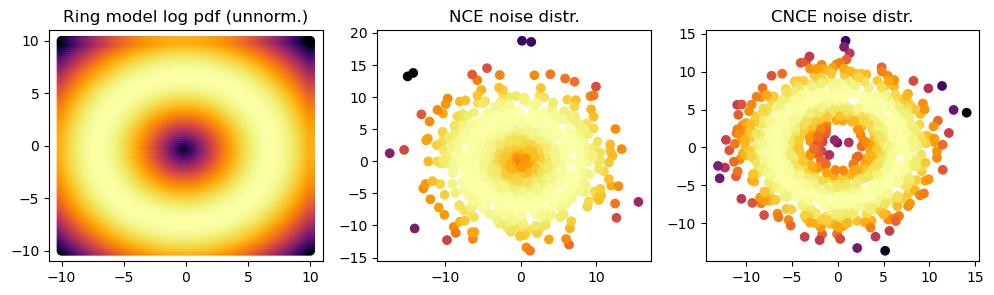

In [82]:
# 2D example
num_dims = 2
mu, precision = 7, 1


# Ring model pdf 
y_grid = get_grid_data()
log_pdf = unnorm_ring_model_log_pdf(y_grid, mu=mu, precision=precision)

# Sample from noise distr. based on some real training data
num_samples = 1000
y = RingModelDataset(sample_size=num_samples, num_dims=num_dims, mu=mu, precision=precision, 
                     root_dir="res/datasets/example_data").get_full_data()

# NCE 
samples_nce = sample_nce(y, num_samples)
log_pdf_nce = unnorm_ring_model_log_pdf(y_samples_nce, mu=mu, precision=precision)

# CNCE 
samples_cnce = sample_cnce(y, num_samples, mu, np.log(precision))
log_pdf_cnce = unnorm_ring_model_log_pdf(y_samples_cnce, mu=mu, precision=precision)


# Visualise
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

ax[0].scatter(y_grid[:, 0], y_grid[:, 1], c=log_pdf, cmap='inferno')
ax[0].set_title("Ring model log pdf (unnorm.)")

ax[1].scatter(y_samples_nce[:, 0], y_samples_nce[:, 1], c=log_pdf_nce, cmap='inferno')
ax[1].set_title("NCE noise distr.")

ax[2].scatter(y_samples_cnce[:, 0], y_samples_cnce[:, 1], c=log_pdf_cnce, cmap='inferno')
ax[2].set_title("CNCE noise distr.")
            

plt.show()


## EXPERIMENTS

In [83]:
# Data specs
num_dims = 5

# Experiments specs
num_samples = [20, 50, 100, 200]
num_neg_samples = [2, 5, 10]
reps = 10

# Criteria 
criteria = [NceBinaryCrit, CondNceCrit]
crit_labels = ["binary", "conditional"]

# Training specs
batch_size = 32
num_epochs = 100

In [84]:
# Run experiments

error_res = np.zeros((len(num_samples), len(num_neg_samples), len(criteria), reps))

# Sorry för alla loopar
for i, N in enumerate(num_samples):
    
    for j, J in enumerate(num_neg_samples):
        
        for rep in range(reps):
            
            # Get data 
            mu, precision, _ = generate_true_params()
            error_metric = PrecisionErrorMetric(true_precision=precision).metric            
                        
            training_data = RingModelDataset(sample_size=N, num_dims=num_dims, mu=mu.numpy(), precision=precision.numpy(), 
                                             root_dir="res/datasets/ring_data_size_" + str(N) + "_nn_" + str(J) + "_rep_" + str(rep))
            train_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
    
            # Initialise           
            _, log_precision_init, log_z_init = initialise_params()
    
            # Get noise distr. params
            mu_noise_nce, cov_noise_nce = get_nce_noise_distr_par(training_data.get_full_data())
            cov_noise_cnce = get_cnce_noise_distr_par(training_data.get_full_data(), J, mu, log_precision_init)
                        
            for k, (crit, lab) in enumerate(zip(criteria, crit_labels)):
            
                if crit == NceBinaryCrit: # TODO: Nicer way to do this comparison?
                    p_m = RingModelNCE(mu=mu, log_precision=log_precision_init, log_part_fn=log_z_init)
                else:
                    p_m = RingModel(mu=mu, log_precision=log_precision_init)
                    
                if crit == CondNceCrit:
                    p_n = ConditionalMultivariateNormal(cov=cov_noise_cnce)
                else:
                    p_n = MultivariateNormal(mu=mu_noise_nce, cov=cov_noise_nce)
                    
                criterion = crit(p_m, p_n)
                
                save_dir = "res/param_error_" + lab + "_samples_" + str(N) + "_num_neg_" + str(J) + "_rep_" + str(rep)
                error_res[i, j, k, rep] = train_model(criterion, error_metric, train_loader, save_dir, neg_sample_size=J, num_epochs=num_epochs,
                                                      stopping_condition=no_change_stopping_condition)

np.save("res/final_param_error_ring_model_all", error_res)

C:\Users\amaol67\PycharmProjects\deep_ext_obj\nbs\..\src\models\ring_model\ring_model.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.log_precision = torch.nn.Parameter(torch.tensor(log_precision), requires_grad=True)
C:\Users\amaol67\PycharmProjects\deep_ext_obj\nbs\..\src\models\ring_model\ring_model.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.log_part_fn = torch.nn.Parameter(torch.tensor(log_part_fn), requires_grad=True)


[1] loss: 0.857
[1] evaluation metric: 4.682
[2] loss: -0.127
[2] evaluation metric: 5.214
[3] loss: -0.644
[3] evaluation metric: 5.495
[4] loss: -2.221
[4] evaluation metric: 5.597
[5] loss: -3.054
[5] evaluation metric: 5.636
[6] loss: -2.444
[6] evaluation metric: 5.721
[7] loss: -2.607
[7] evaluation metric: 5.795
[8] loss: -2.184
[8] evaluation metric: 5.916
[9] loss: -2.923
[9] evaluation metric: 5.965
[10] loss: -3.354
[10] evaluation metric: 5.990
[11] loss: -3.999
[11] evaluation metric: 6.005
[12] loss: -3.660
[12] evaluation metric: 6.017
[13] loss: -3.652
[13] evaluation metric: 6.037
[14] loss: -4.158
[14] evaluation metric: 6.044
[15] loss: -4.090
[15] evaluation metric: 6.059
[16] loss: -4.131
[16] evaluation metric: 6.072
[17] loss: -4.032
[17] evaluation metric: 6.086
[18] loss: -4.183
[18] evaluation metric: 6.099
[19] loss: -4.540
[19] evaluation metric: 6.110
[20] loss: -4.389
[20] evaluation metric: 6.122
[21] loss: -4.163
[21] evaluation metric: 6.136
[22] loss: 

[41] loss: -7.205
[41] evaluation metric: 2.614
[42] loss: -6.881
[42] evaluation metric: 2.621
[43] loss: -7.296
[43] evaluation metric: 2.626
[44] loss: -7.367
[44] evaluation metric: 2.630
[45] loss: -7.511
[45] evaluation metric: 2.634
[46] loss: -7.901
[46] evaluation metric: 2.639
[47] loss: -8.122
[47] evaluation metric: 2.641
[48] loss: -7.889
[48] evaluation metric: 2.644
[49] loss: -8.064
[49] evaluation metric: 2.646
[50] loss: -8.023
[50] evaluation metric: 2.650
[51] loss: -8.288
[51] evaluation metric: 2.653
[52] loss: -8.428
[52] evaluation metric: 2.656
[53] loss: -8.444
[53] evaluation metric: 2.659
[54] loss: -8.519
[54] evaluation metric: 2.664
[55] loss: -8.670
[55] evaluation metric: 2.667
[56] loss: -8.745
[56] evaluation metric: 2.670
[57] loss: -9.153
[57] evaluation metric: 2.671
[58] loss: -8.830
[58] evaluation metric: 2.674
[59] loss: -8.414
[59] evaluation metric: 2.679
[60] loss: -9.175
[60] evaluation metric: 2.680
[61] loss: -9.607
[61] evaluation metric

[61] loss: -9.441
[61] evaluation metric: 0.182
[62] loss: -9.595
[62] evaluation metric: 0.183
[63] loss: -9.737
[63] evaluation metric: 0.183
[64] loss: -9.916
[64] evaluation metric: 0.184
[65] loss: -10.106
[65] evaluation metric: 0.184
[66] loss: -10.170
[66] evaluation metric: 0.184
[67] loss: -10.200
[67] evaluation metric: 0.185
[68] loss: -10.134
[68] evaluation metric: 0.185
[69] loss: -10.441
[69] evaluation metric: 0.185
[70] loss: -10.452
[70] evaluation metric: 0.186
[71] loss: -10.830
[71] evaluation metric: 0.186
[72] loss: -10.418
[72] evaluation metric: 0.186
[73] loss: -10.856
[73] evaluation metric: 0.187
[74] loss: -10.759
[74] evaluation metric: 0.187
[75] loss: -10.948
[75] evaluation metric: 0.187
[76] loss: -11.023
[76] evaluation metric: 0.188
[77] loss: -10.989
[77] evaluation metric: 0.188
[78] loss: -11.356
[78] evaluation metric: 0.188
[79] loss: -11.332
[79] evaluation metric: 0.189
[80] loss: -11.562
[80] evaluation metric: 0.189
[81] loss: -11.692
[81] 

[69] loss: -7.564
[69] evaluation metric: 0.162
[70] loss: -7.877
[70] evaluation metric: 0.163
[71] loss: -7.661
[71] evaluation metric: 0.163
[72] loss: -7.935
[72] evaluation metric: 0.164
[73] loss: -7.976
[73] evaluation metric: 0.165
[74] loss: -7.897
[74] evaluation metric: 0.165
[75] loss: -8.022
[75] evaluation metric: 0.166
[76] loss: -8.246
[76] evaluation metric: 0.166
[77] loss: -8.278
[77] evaluation metric: 0.167
[78] loss: -8.373
[78] evaluation metric: 0.168
[79] loss: -8.732
[79] evaluation metric: 0.168
[80] loss: -8.762
[80] evaluation metric: 0.168
[81] loss: -8.909
[81] evaluation metric: 0.169
[82] loss: -8.955
[82] evaluation metric: 0.169
[83] loss: -8.960
[83] evaluation metric: 0.169
[84] loss: -8.894
[84] evaluation metric: 0.170
[85] loss: -9.044
[85] evaluation metric: 0.170
[86] loss: -9.357
[86] evaluation metric: 0.171
[87] loss: -9.430
[87] evaluation metric: 0.171
[88] loss: -9.646
[88] evaluation metric: 0.172
[89] loss: -9.773
[89] evaluation metric

[9] loss: 0.433
[9] evaluation metric: 38.584
[10] loss: 0.455
[10] evaluation metric: 38.502
[11] loss: 0.492
[11] evaluation metric: 38.426
[12] loss: 0.468
[12] evaluation metric: 38.359
[13] loss: 0.414
[13] evaluation metric: 38.283
[14] loss: 0.467
[14] evaluation metric: 38.200
[15] loss: 0.469
[15] evaluation metric: 38.115
[16] loss: 0.460
[16] evaluation metric: 38.014
[17] loss: 0.487
[17] evaluation metric: 37.936
[18] loss: 0.495
[18] evaluation metric: 37.862
[19] loss: 0.437
[19] evaluation metric: 37.776
[20] loss: 0.424
[20] evaluation metric: 37.673
[21] loss: 0.501
[21] evaluation metric: 37.601
[22] loss: 0.454
[22] evaluation metric: 37.512
[23] loss: 0.422
[23] evaluation metric: 37.423
[24] loss: 0.490
[24] evaluation metric: 37.331
[25] loss: 0.483
[25] evaluation metric: 37.242
[26] loss: 0.454
[26] evaluation metric: 37.157
[27] loss: 0.421
[27] evaluation metric: 37.036
[28] loss: 0.454
[28] evaluation metric: 36.947
[29] loss: 0.480
[29] evaluation metric: 3

[100] loss: -11.463
[100] evaluation metric: 0.309
Finished training
Data saved
[1] loss: 0.673
[1] evaluation metric: 0.194
[2] loss: 0.734
[2] evaluation metric: 0.179
[3] loss: 0.903
[3] evaluation metric: 0.150
[4] loss: 0.634
[4] evaluation metric: 0.141
[5] loss: 0.728
[5] evaluation metric: 0.128
[6] loss: 0.785
[6] evaluation metric: 0.113
[7] loss: 0.786
[7] evaluation metric: 0.100
[8] loss: 0.727
[8] evaluation metric: 0.090
[9] loss: 0.780
[9] evaluation metric: 0.078
[10] loss: 0.732
[10] evaluation metric: 0.069
[11] loss: 0.603
[11] evaluation metric: 0.065
[12] loss: 0.572
[12] evaluation metric: 0.061
[13] loss: 0.757
[13] evaluation metric: 0.052
[14] loss: 0.739
[14] evaluation metric: 0.046
[15] loss: 0.744
[15] evaluation metric: 0.042
[16] loss: 0.810
[16] evaluation metric: 0.035
[17] loss: 0.772
[17] evaluation metric: 0.029
[18] loss: 0.749
[18] evaluation metric: 0.025
[19] loss: 0.645
[19] evaluation metric: 0.022
[20] loss: 0.651
[20] evaluation metric: 0.02

[53] loss: 0.462
[53] evaluation metric: 1.056
[54] loss: 0.472
[54] evaluation metric: 1.049
[55] loss: 0.516
[55] evaluation metric: 1.046
[56] loss: 0.458
[56] evaluation metric: 1.030
[57] loss: 0.495
[57] evaluation metric: 1.012
[58] loss: 0.427
[58] evaluation metric: 0.993
[59] loss: 0.448
[59] evaluation metric: 0.981
[60] loss: 0.473
[60] evaluation metric: 0.966
[61] loss: 0.397
[61] evaluation metric: 0.952
[62] loss: 0.356
[62] evaluation metric: 0.928
[63] loss: 0.489
[63] evaluation metric: 0.914
[64] loss: 0.395
[64] evaluation metric: 0.890
[65] loss: 0.494
[65] evaluation metric: 0.875
[66] loss: 0.529
[66] evaluation metric: 0.862
[67] loss: 0.464
[67] evaluation metric: 0.853
[68] loss: 0.452
[68] evaluation metric: 0.839
[69] loss: 0.429
[69] evaluation metric: 0.823
[70] loss: 0.440
[70] evaluation metric: 0.811
[71] loss: 0.428
[71] evaluation metric: 0.795
[72] loss: 0.371
[72] evaluation metric: 0.776
[73] loss: 0.384
[73] evaluation metric: 0.766
[74] loss: 0.

[40] loss: 0.409
[40] evaluation metric: 1.124
[41] loss: 0.367
[41] evaluation metric: 1.088
[42] loss: 0.401
[42] evaluation metric: 1.066
[43] loss: 0.333
[43] evaluation metric: 1.022
[44] loss: 0.375
[44] evaluation metric: 0.991
[45] loss: 0.441
[45] evaluation metric: 0.965
[46] loss: 0.288
[46] evaluation metric: 0.932
[47] loss: 0.425
[47] evaluation metric: 0.899
[48] loss: 0.328
[48] evaluation metric: 0.865
[49] loss: 0.415
[49] evaluation metric: 0.846
[50] loss: 0.298
[50] evaluation metric: 0.806
[51] loss: 0.355
[51] evaluation metric: 0.778
[52] loss: 0.350
[52] evaluation metric: 0.745
[53] loss: 0.394
[53] evaluation metric: 0.719
[54] loss: 0.327
[54] evaluation metric: 0.686
[55] loss: 0.432
[55] evaluation metric: 0.667
[56] loss: 0.387
[56] evaluation metric: 0.638
[57] loss: 0.253
[57] evaluation metric: 0.606
[58] loss: 0.310
[58] evaluation metric: 0.573
[59] loss: 0.338
[59] evaluation metric: 0.548
[60] loss: 0.316
[60] evaluation metric: 0.519
[61] loss: 0.

[24] loss: 0.704
[24] evaluation metric: 0.025
[25] loss: 0.627
[25] evaluation metric: 0.021
[26] loss: 0.608
[26] evaluation metric: 0.020
[27] loss: 0.472
[27] evaluation metric: 0.020
[28] loss: 0.655
[28] evaluation metric: 0.018
[29] loss: 0.490
[29] evaluation metric: 0.017
[30] loss: 0.540
[30] evaluation metric: 0.016
[31] loss: 0.639
[31] evaluation metric: 0.014
[32] loss: 0.474
[32] evaluation metric: 0.015
[33] loss: 0.604
[33] evaluation metric: 0.013
[34] loss: 0.617
[34] evaluation metric: 0.012
[35] loss: 0.680
[35] evaluation metric: 0.010
[36] loss: 0.520
[36] evaluation metric: 0.010
[37] loss: 0.697
[37] evaluation metric: 0.008
[38] loss: 0.585
[38] evaluation metric: 0.006
[39] loss: 0.614
[39] evaluation metric: 0.005
[40] loss: 0.557
[40] evaluation metric: 0.004
[41] loss: 0.587
[41] evaluation metric: 0.003
[42] loss: 0.648
[42] evaluation metric: 0.002
[43] loss: 0.596
[43] evaluation metric: 0.002
[44] loss: 0.491
[44] evaluation metric: 0.002
[45] loss: 0.

[13] loss: 0.406
[13] evaluation metric: 0.005
[14] loss: 0.538
[14] evaluation metric: 0.005
[15] loss: 0.427
[15] evaluation metric: 0.005
[16] loss: 0.521
[16] evaluation metric: 0.005
[17] loss: 0.412
[17] evaluation metric: 0.006
[18] loss: 0.537
[18] evaluation metric: 0.006
[19] loss: 0.376
[19] evaluation metric: 0.007
[20] loss: 0.497
[20] evaluation metric: 0.007
[21] loss: 0.462
[21] evaluation metric: 0.008
[22] loss: 0.480
[22] evaluation metric: 0.009
[23] loss: 0.446
[23] evaluation metric: 0.010
[24] loss: 0.452
[24] evaluation metric: 0.010
[25] loss: 0.416
[25] evaluation metric: 0.011
[26] loss: 0.532
[26] evaluation metric: 0.011
[27] loss: 0.512
[27] evaluation metric: 0.011
[28] loss: 0.429
[28] evaluation metric: 0.013
[29] loss: 0.420
[29] evaluation metric: 0.013
[30] loss: 0.442
[30] evaluation metric: 0.014
[31] loss: 0.453
[31] evaluation metric: 0.015
[32] loss: 0.369
[32] evaluation metric: 0.016
[33] loss: 0.438
[33] evaluation metric: 0.017
[34] loss: 0.

[25] loss: 0.404
[25] evaluation metric: 0.083
[26] loss: 0.313
[26] evaluation metric: 0.084
[27] loss: 0.459
[27] evaluation metric: 0.076
[28] loss: 0.457
[28] evaluation metric: 0.070
[29] loss: 0.403
[29] evaluation metric: 0.063
[30] loss: 0.379
[30] evaluation metric: 0.059
[31] loss: 0.476
[31] evaluation metric: 0.051
[32] loss: 0.394
[32] evaluation metric: 0.049
[33] loss: 0.425
[33] evaluation metric: 0.049
[34] loss: 0.411
[34] evaluation metric: 0.047
[35] loss: 0.436
[35] evaluation metric: 0.044
[36] loss: 0.342
[36] evaluation metric: 0.042
[37] loss: 0.342
[37] evaluation metric: 0.042
[38] loss: 0.406
[38] evaluation metric: 0.041
[39] loss: 0.414
[39] evaluation metric: 0.041
[40] loss: 0.393
[40] evaluation metric: 0.041
[41] loss: 0.372
[41] evaluation metric: 0.041
[42] loss: 0.372
[42] evaluation metric: 0.039
[43] loss: 0.405
[43] evaluation metric: 0.038
[44] loss: 0.461
[44] evaluation metric: 0.033
[45] loss: 0.317
[45] evaluation metric: 0.034
[46] loss: 0.

[28] loss: 0.675
[28] evaluation metric: 0.498
[29] loss: 0.715
[29] evaluation metric: 0.456
[30] loss: 0.719
[30] evaluation metric: 0.415
[31] loss: 0.652
[31] evaluation metric: 0.381
[32] loss: 0.749
[32] evaluation metric: 0.337
[33] loss: 0.665
[33] evaluation metric: 0.317
[34] loss: 0.612
[34] evaluation metric: 0.304
[35] loss: 0.754
[35] evaluation metric: 0.265
[36] loss: 0.644
[36] evaluation metric: 0.250
[37] loss: 0.556
[37] evaluation metric: 0.244
[38] loss: 0.721
[38] evaluation metric: 0.220
[39] loss: 0.701
[39] evaluation metric: 0.200
[40] loss: 0.518
[40] evaluation metric: 0.198
[41] loss: 0.671
[41] evaluation metric: 0.181
[42] loss: 0.681
[42] evaluation metric: 0.162
[43] loss: 0.668
[43] evaluation metric: 0.148
[44] loss: 0.586
[44] evaluation metric: 0.142
[45] loss: 0.679
[45] evaluation metric: 0.131
[46] loss: 0.641
[46] evaluation metric: 0.122
[47] loss: 0.654
[47] evaluation metric: 0.113
[48] loss: 0.679
[48] evaluation metric: 0.103
[49] loss: 0.

[39] loss: 0.525
[39] evaluation metric: 0.000
[40] loss: 0.454
[40] evaluation metric: 0.000
[41] loss: 0.383
[41] evaluation metric: 0.000
[42] loss: 0.504
[42] evaluation metric: 0.000
[43] loss: 0.485
[43] evaluation metric: 0.000
[44] loss: 0.478
[44] evaluation metric: 0.000
[45] loss: 0.524
[45] evaluation metric: 0.000
[46] loss: 0.454
[46] evaluation metric: 0.000
[47] loss: 0.392
[47] evaluation metric: 0.000
[48] loss: 0.471
[48] evaluation metric: 0.000
[49] loss: 0.481
[49] evaluation metric: 0.000
[50] loss: 0.516
[50] evaluation metric: 0.000
[51] loss: 0.526
[51] evaluation metric: 0.000
[52] loss: 0.525
[52] evaluation metric: 0.000
[53] loss: 0.471
[53] evaluation metric: 0.000
[54] loss: 0.454
[54] evaluation metric: 0.000
[55] loss: 0.506
[55] evaluation metric: 0.000
[56] loss: 0.520
[56] evaluation metric: 0.000
[57] loss: 0.502
[57] evaluation metric: 0.000
[58] loss: 0.543
[58] evaluation metric: 0.000
[59] loss: 0.493
[59] evaluation metric: 0.000
[60] loss: 0.

[53] loss: 0.456
[53] evaluation metric: 0.342
[54] loss: 0.451
[54] evaluation metric: 0.342
[55] loss: 0.469
[55] evaluation metric: 0.345
[56] loss: 0.486
[56] evaluation metric: 0.353
[57] loss: 0.482
[57] evaluation metric: 0.354
[58] loss: 0.472
[58] evaluation metric: 0.356
[59] loss: 0.408
[59] evaluation metric: 0.350
[60] loss: 0.502
[60] evaluation metric: 0.356
[61] loss: 0.476
[61] evaluation metric: 0.352
[62] loss: 0.409
[62] evaluation metric: 0.345
[63] loss: 0.445
[63] evaluation metric: 0.340
[64] loss: 0.342
[64] evaluation metric: 0.331
[65] loss: 0.437
[65] evaluation metric: 0.329
[66] loss: 0.469
[66] evaluation metric: 0.328
[67] loss: 0.473
[67] evaluation metric: 0.331
[68] loss: 0.416
[68] evaluation metric: 0.327
[69] loss: 0.432
[69] evaluation metric: 0.323
[70] loss: 0.414
[70] evaluation metric: 0.319
[71] loss: 0.430
[71] evaluation metric: 0.321
[72] loss: 0.435
[72] evaluation metric: 0.318
[73] loss: 0.461
[73] evaluation metric: 0.320
[74] loss: 0.

[36] loss: 0.202
[36] evaluation metric: 0.024
[37] loss: 0.282
[37] evaluation metric: 0.021
[38] loss: 0.291
[38] evaluation metric: 0.018
[39] loss: 0.288
[39] evaluation metric: 0.016
[40] loss: 0.242
[40] evaluation metric: 0.013
[41] loss: 0.345
[41] evaluation metric: 0.014
[42] loss: 0.349
[42] evaluation metric: 0.013
[43] loss: 0.284
[43] evaluation metric: 0.010
[44] loss: 0.283
[44] evaluation metric: 0.008
[45] loss: 0.227
[45] evaluation metric: 0.006
[46] loss: 0.265
[46] evaluation metric: 0.005
[47] loss: 0.300
[47] evaluation metric: 0.003
[48] loss: 0.302
[48] evaluation metric: 0.003
[49] loss: 0.321
[49] evaluation metric: 0.002
[50] loss: 0.325
[50] evaluation metric: 0.002
[51] loss: 0.273
[51] evaluation metric: 0.001
[52] loss: 0.304
[52] evaluation metric: 0.000
[53] loss: 0.244
[53] evaluation metric: 0.000
[54] loss: 0.228
[54] evaluation metric: 0.000
[55] loss: 0.257
[55] evaluation metric: 0.000
[56] loss: 0.354
[56] evaluation metric: 0.000
[57] loss: 0.

[46] loss: 0.491
[46] evaluation metric: 0.239
[47] loss: 0.465
[47] evaluation metric: 0.229
[48] loss: 0.491
[48] evaluation metric: 0.211
[49] loss: 0.426
[49] evaluation metric: 0.201
[50] loss: 0.483
[50] evaluation metric: 0.180
[51] loss: 0.315
[51] evaluation metric: 0.184
[52] loss: 0.287
[52] evaluation metric: 0.188
[53] loss: 0.447
[53] evaluation metric: 0.176
[54] loss: 0.369
[54] evaluation metric: 0.175
[55] loss: 0.325
[55] evaluation metric: 0.174
[56] loss: 0.506
[56] evaluation metric: 0.160
[57] loss: 0.544
[57] evaluation metric: 0.142
[58] loss: 0.343
[58] evaluation metric: 0.143
[59] loss: 0.538
[59] evaluation metric: 0.126
[60] loss: 0.420
[60] evaluation metric: 0.119
[61] loss: 0.550
[61] evaluation metric: 0.101
[62] loss: 0.383
[62] evaluation metric: 0.097
[63] loss: 0.551
[63] evaluation metric: 0.081
[64] loss: 0.382
[64] evaluation metric: 0.076
[65] loss: 0.407
[65] evaluation metric: 0.075
[66] loss: 0.426
[66] evaluation metric: 0.070
[67] loss: 0.

[25] loss: 0.552
[25] evaluation metric: 0.576
[26] loss: 0.471
[26] evaluation metric: 0.558
[27] loss: 0.474
[27] evaluation metric: 0.547
[28] loss: 0.557
[28] evaluation metric: 0.524
[29] loss: 0.463
[29] evaluation metric: 0.514
[30] loss: 0.499
[30] evaluation metric: 0.507
[31] loss: 0.597
[31] evaluation metric: 0.482
[32] loss: 0.564
[32] evaluation metric: 0.462
[33] loss: 0.500
[33] evaluation metric: 0.449
[34] loss: 0.487
[34] evaluation metric: 0.438
[35] loss: 0.512
[35] evaluation metric: 0.424
[36] loss: 0.547
[36] evaluation metric: 0.407
[37] loss: 0.556
[37] evaluation metric: 0.389
[38] loss: 0.545
[38] evaluation metric: 0.376
[39] loss: 0.491
[39] evaluation metric: 0.363
[40] loss: 0.586
[40] evaluation metric: 0.342
[41] loss: 0.554
[41] evaluation metric: 0.330
[42] loss: 0.557
[42] evaluation metric: 0.319
[43] loss: 0.505
[43] evaluation metric: 0.313
[44] loss: 0.512
[44] evaluation metric: 0.304
[45] loss: 0.509
[45] evaluation metric: 0.293
[46] loss: 0.

[37] loss: 0.459
[37] evaluation metric: 0.033
[38] loss: 0.342
[38] evaluation metric: 0.034
[39] loss: 0.519
[39] evaluation metric: 0.033
[40] loss: 0.376
[40] evaluation metric: 0.034
[41] loss: 0.480
[41] evaluation metric: 0.034
[42] loss: 0.513
[42] evaluation metric: 0.032
[43] loss: 0.436
[43] evaluation metric: 0.032
[44] loss: 0.380
[44] evaluation metric: 0.033
[45] loss: 0.434
[45] evaluation metric: 0.033
[46] loss: 0.359
[46] evaluation metric: 0.034
[47] loss: 0.499
[47] evaluation metric: 0.032
[48] loss: 0.436
[48] evaluation metric: 0.032
[49] loss: 0.450
[49] evaluation metric: 0.031
[50] loss: 0.369
[50] evaluation metric: 0.032
[51] loss: 0.497
[51] evaluation metric: 0.032
[52] loss: 0.431
[52] evaluation metric: 0.032
[53] loss: 0.420
[53] evaluation metric: 0.033
[54] loss: 0.437
[54] evaluation metric: 0.033
[55] loss: 0.444
[55] evaluation metric: 0.032
[56] loss: 0.436
[56] evaluation metric: 0.032
[57] loss: 0.480
[57] evaluation metric: 0.030
[58] loss: 0.

[44] loss: 0.274
[44] evaluation metric: 17.168
[45] loss: 0.278
[45] evaluation metric: 17.032
[46] loss: 0.270
[46] evaluation metric: 16.869
[47] loss: 0.257
[47] evaluation metric: 16.755
[48] loss: 0.292
[48] evaluation metric: 16.676
[49] loss: 0.261
[49] evaluation metric: 16.511
[50] loss: 0.258
[50] evaluation metric: 16.342
[51] loss: 0.280
[51] evaluation metric: 16.189
[52] loss: 0.265
[52] evaluation metric: 16.038
[53] loss: 0.288
[53] evaluation metric: 15.886
[54] loss: 0.244
[54] evaluation metric: 15.745
[55] loss: 0.334
[55] evaluation metric: 15.624
[56] loss: 0.249
[56] evaluation metric: 15.501
[57] loss: 0.281
[57] evaluation metric: 15.402
[58] loss: 0.269
[58] evaluation metric: 15.263
[59] loss: 0.269
[59] evaluation metric: 15.149
[60] loss: 0.264
[60] evaluation metric: 15.072
[61] loss: 0.229
[61] evaluation metric: 14.915
[62] loss: 0.272
[62] evaluation metric: 14.812
[63] loss: 0.275
[63] evaluation metric: 14.676
[64] loss: 0.336
[64] evaluation metric:

[35] loss: 0.485
[35] evaluation metric: 0.819
[36] loss: 0.488
[36] evaluation metric: 0.785
[37] loss: 0.391
[37] evaluation metric: 0.762
[38] loss: 0.671
[38] evaluation metric: 0.677
[39] loss: 0.412
[39] evaluation metric: 0.664
[40] loss: 0.495
[40] evaluation metric: 0.637
[41] loss: 0.455
[41] evaluation metric: 0.616
[42] loss: 0.487
[42] evaluation metric: 0.595
[43] loss: 0.523
[43] evaluation metric: 0.556
[44] loss: 0.433
[44] evaluation metric: 0.546
[45] loss: 0.550
[45] evaluation metric: 0.512
[46] loss: 0.525
[46] evaluation metric: 0.472
[47] loss: 0.622
[47] evaluation metric: 0.434
[48] loss: 0.555
[48] evaluation metric: 0.407
[49] loss: 0.493
[49] evaluation metric: 0.391
[50] loss: 0.586
[50] evaluation metric: 0.364
[51] loss: 0.502
[51] evaluation metric: 0.354
[52] loss: 0.517
[52] evaluation metric: 0.342
[53] loss: 0.452
[53] evaluation metric: 0.345
[54] loss: 0.532
[54] evaluation metric: 0.331
[55] loss: 0.464
[55] evaluation metric: 0.316
[56] loss: 0.

[35] loss: 0.591
[35] evaluation metric: 0.007
[36] loss: 0.561
[36] evaluation metric: 0.006
[37] loss: 0.574
[37] evaluation metric: 0.006
[38] loss: 0.576
[38] evaluation metric: 0.006
[39] loss: 0.589
[39] evaluation metric: 0.006
[40] loss: 0.524
[40] evaluation metric: 0.005
[41] loss: 0.530
[41] evaluation metric: 0.005
[42] loss: 0.611
[42] evaluation metric: 0.005
[43] loss: 0.542
[43] evaluation metric: 0.004
[44] loss: 0.542
[44] evaluation metric: 0.004
[45] loss: 0.521
[45] evaluation metric: 0.004
[46] loss: 0.627
[46] evaluation metric: 0.004
[47] loss: 0.568
[47] evaluation metric: 0.004
[48] loss: 0.552
[48] evaluation metric: 0.003
[49] loss: 0.534
[49] evaluation metric: 0.003
[50] loss: 0.581
[50] evaluation metric: 0.003
[51] loss: 0.562
[51] evaluation metric: 0.003
[52] loss: 0.541
[52] evaluation metric: 0.003
[53] loss: 0.560
[53] evaluation metric: 0.003
[54] loss: 0.561
[54] evaluation metric: 0.002
[55] loss: 0.587
[55] evaluation metric: 0.002
[56] loss: 0.

[53] loss: 0.357
[53] evaluation metric: 0.336
[54] loss: 0.348
[54] evaluation metric: 0.345
[55] loss: 0.364
[55] evaluation metric: 0.352
[56] loss: 0.399
[56] evaluation metric: 0.355
[57] loss: 0.349
[57] evaluation metric: 0.367
[58] loss: 0.380
[58] evaluation metric: 0.373
[59] loss: 0.343
[59] evaluation metric: 0.381
[60] loss: 0.347
[60] evaluation metric: 0.391
[61] loss: 0.343
[61] evaluation metric: 0.401
[62] loss: 0.363
[62] evaluation metric: 0.406
[63] loss: 0.370
[63] evaluation metric: 0.413
[64] loss: 0.314
[64] evaluation metric: 0.426
[65] loss: 0.331
[65] evaluation metric: 0.437
[66] loss: 0.325
[66] evaluation metric: 0.445
[67] loss: 0.345
[67] evaluation metric: 0.456
[68] loss: 0.347
[68] evaluation metric: 0.469
[69] loss: 0.311
[69] evaluation metric: 0.479
[70] loss: 0.293
[70] evaluation metric: 0.494
[71] loss: 0.328
[71] evaluation metric: 0.508
[72] loss: 0.333
[72] evaluation metric: 0.519
[73] loss: 0.381
[73] evaluation metric: 0.519
[74] loss: 0.

[35] loss: 0.531
[35] evaluation metric: 0.210
[36] loss: 0.509
[36] evaluation metric: 0.202
[37] loss: 0.486
[37] evaluation metric: 0.201
[38] loss: 0.556
[38] evaluation metric: 0.193
[39] loss: 0.498
[39] evaluation metric: 0.187
[40] loss: 0.530
[40] evaluation metric: 0.181
[41] loss: 0.506
[41] evaluation metric: 0.177
[42] loss: 0.588
[42] evaluation metric: 0.167
[43] loss: 0.502
[43] evaluation metric: 0.163
[44] loss: 0.498
[44] evaluation metric: 0.160
[45] loss: 0.613
[45] evaluation metric: 0.150
[46] loss: 0.512
[46] evaluation metric: 0.144
[47] loss: 0.479
[47] evaluation metric: 0.143
[48] loss: 0.493
[48] evaluation metric: 0.139
[49] loss: 0.648
[49] evaluation metric: 0.128
[50] loss: 0.495
[50] evaluation metric: 0.127
[51] loss: 0.581
[51] evaluation metric: 0.120
[52] loss: 0.483
[52] evaluation metric: 0.118
[53] loss: 0.546
[53] evaluation metric: 0.114
[54] loss: 0.507
[54] evaluation metric: 0.112
[55] loss: 0.503
[55] evaluation metric: 0.110
[56] loss: 0.

[67] loss: 0.498
[67] evaluation metric: 0.143
[68] loss: 0.456
[68] evaluation metric: 0.142
[69] loss: 0.485
[69] evaluation metric: 0.137
[70] loss: 0.519
[70] evaluation metric: 0.131
[71] loss: 0.553
[71] evaluation metric: 0.123
[72] loss: 0.498
[72] evaluation metric: 0.121
[73] loss: 0.573
[73] evaluation metric: 0.112
[74] loss: 0.498
[74] evaluation metric: 0.107
[75] loss: 0.456
[75] evaluation metric: 0.106
[76] loss: 0.494
[76] evaluation metric: 0.103
[77] loss: 0.502
[77] evaluation metric: 0.098
[78] loss: 0.475
[78] evaluation metric: 0.095
[79] loss: 0.476
[79] evaluation metric: 0.094
[80] loss: 0.462
[80] evaluation metric: 0.094
[81] loss: 0.536
[81] evaluation metric: 0.088
[82] loss: 0.471
[82] evaluation metric: 0.088
[83] loss: 0.516
[83] evaluation metric: 0.084
[84] loss: 0.519
[84] evaluation metric: 0.082
[85] loss: 0.522
[85] evaluation metric: 0.078
[86] loss: 0.471
[86] evaluation metric: 0.078
[87] loss: 0.468
[87] evaluation metric: 0.077
[88] loss: 0.

[64] loss: 0.620
[64] evaluation metric: 0.013
[65] loss: 0.620
[65] evaluation metric: 0.014
[66] loss: 0.570
[66] evaluation metric: 0.013
[67] loss: 0.613
[67] evaluation metric: 0.014
[68] loss: 0.576
[68] evaluation metric: 0.013
[69] loss: 0.583
[69] evaluation metric: 0.014
[70] loss: 0.615
[70] evaluation metric: 0.014
[71] loss: 0.584
[71] evaluation metric: 0.014
[72] loss: 0.601
[72] evaluation metric: 0.014
[73] loss: 0.563
[73] evaluation metric: 0.013
[74] loss: 0.592
[74] evaluation metric: 0.013
[75] loss: 0.591
[75] evaluation metric: 0.013
[76] loss: 0.643
[76] evaluation metric: 0.014
[77] loss: 0.605
[77] evaluation metric: 0.014
[78] loss: 0.596
[78] evaluation metric: 0.014
[79] loss: 0.597
[79] evaluation metric: 0.014
[80] loss: 0.598
[80] evaluation metric: 0.014
[81] loss: 0.637
[81] evaluation metric: 0.015
[82] loss: 0.598
[82] evaluation metric: 0.015
[83] loss: 0.633
[83] evaluation metric: 0.015
[84] loss: 0.574
[84] evaluation metric: 0.015
[85] loss: 0.

[62] loss: 0.607
[62] evaluation metric: 0.079
[63] loss: 0.572
[63] evaluation metric: 0.073
[64] loss: 0.649
[64] evaluation metric: 0.063
[65] loss: 0.628
[65] evaluation metric: 0.055
[66] loss: 0.550
[66] evaluation metric: 0.053
[67] loss: 0.600
[67] evaluation metric: 0.048
[68] loss: 0.646
[68] evaluation metric: 0.041
[69] loss: 0.546
[69] evaluation metric: 0.038
[70] loss: 0.564
[70] evaluation metric: 0.036
[71] loss: 0.544
[71] evaluation metric: 0.035
[72] loss: 0.571
[72] evaluation metric: 0.033
[73] loss: 0.571
[73] evaluation metric: 0.032
[74] loss: 0.558
[74] evaluation metric: 0.030
[75] loss: 0.618
[75] evaluation metric: 0.027
[76] loss: 0.618
[76] evaluation metric: 0.023
[77] loss: 0.668
[77] evaluation metric: 0.017
[78] loss: 0.649
[78] evaluation metric: 0.013
[79] loss: 0.552
[79] evaluation metric: 0.012
[80] loss: 0.606
[80] evaluation metric: 0.010
[81] loss: 0.585
[81] evaluation metric: 0.009
[82] loss: 0.559
[82] evaluation metric: 0.009
[83] loss: 0.

[45] loss: 0.521
[45] evaluation metric: 0.054
[46] loss: 0.549
[46] evaluation metric: 0.049
[47] loss: 0.582
[47] evaluation metric: 0.044
[48] loss: 0.523
[48] evaluation metric: 0.042
[49] loss: 0.568
[49] evaluation metric: 0.038
[50] loss: 0.611
[50] evaluation metric: 0.033
[51] loss: 0.490
[51] evaluation metric: 0.034
[52] loss: 0.552
[52] evaluation metric: 0.031
[53] loss: 0.503
[53] evaluation metric: 0.031
[54] loss: 0.566
[54] evaluation metric: 0.028
[55] loss: 0.593
[55] evaluation metric: 0.025
[56] loss: 0.564
[56] evaluation metric: 0.022
[57] loss: 0.555
[57] evaluation metric: 0.020
[58] loss: 0.546
[58] evaluation metric: 0.017
[59] loss: 0.526
[59] evaluation metric: 0.017
[60] loss: 0.542
[60] evaluation metric: 0.015
[61] loss: 0.521
[61] evaluation metric: 0.015
[62] loss: 0.521
[62] evaluation metric: 0.014
[63] loss: 0.562
[63] evaluation metric: 0.013
[64] loss: 0.531
[64] evaluation metric: 0.011
[65] loss: 0.530
[65] evaluation metric: 0.010
[66] loss: 0.

[1] loss: 4.412
[1] evaluation metric: 10.175
[2] loss: 4.375
[2] evaluation metric: 11.337
[3] loss: 4.224
[3] evaluation metric: 12.636
[4] loss: 4.208
[4] evaluation metric: 13.849
[5] loss: 4.106
[5] evaluation metric: 15.090
[6] loss: 4.096
[6] evaluation metric: 16.394
[7] loss: 3.936
[7] evaluation metric: 18.034
[8] loss: 3.855
[8] evaluation metric: 19.488
[9] loss: 3.532
[9] evaluation metric: 20.989
[10] loss: 3.546
[10] evaluation metric: 22.179
[11] loss: 3.402
[11] evaluation metric: 23.925
[12] loss: 3.473
[12] evaluation metric: 25.095
[13] loss: 2.993
[13] evaluation metric: 26.397
[14] loss: 2.638
[14] evaluation metric: 27.581
[15] loss: 1.933
[15] evaluation metric: 28.950
[16] loss: 1.943
[16] evaluation metric: 29.713
[17] loss: 0.838
[17] evaluation metric: 30.716
[18] loss: -0.369
[18] evaluation metric: 31.248
[19] loss: -0.083
[19] evaluation metric: 31.788
[20] loss: -0.845
[20] evaluation metric: 32.036
[21] loss: -1.228
[21] evaluation metric: 32.220
[22] l

[27] loss: -2.595
[27] evaluation metric: 0.333
[28] loss: -2.609
[28] evaluation metric: 0.336
[29] loss: -2.811
[29] evaluation metric: 0.338
[30] loss: -3.058
[30] evaluation metric: 0.339
[31] loss: -3.081
[31] evaluation metric: 0.341
[32] loss: -2.993
[32] evaluation metric: 0.344
[33] loss: -3.156
[33] evaluation metric: 0.346
[34] loss: -3.486
[34] evaluation metric: 0.347
[35] loss: -3.505
[35] evaluation metric: 0.349
[36] loss: -3.495
[36] evaluation metric: 0.350
[37] loss: -3.658
[37] evaluation metric: 0.352
[38] loss: -3.738
[38] evaluation metric: 0.353
[39] loss: -4.012
[39] evaluation metric: 0.355
[40] loss: -4.102
[40] evaluation metric: 0.356
[41] loss: -3.875
[41] evaluation metric: 0.357
[42] loss: -4.198
[42] evaluation metric: 0.358
[43] loss: -4.435
[43] evaluation metric: 0.359
[44] loss: -4.292
[44] evaluation metric: 0.360
[45] loss: -4.552
[45] evaluation metric: 0.362
[46] loss: -4.501
[46] evaluation metric: 0.363
[47] loss: -4.709
[47] evaluation metric

[11] loss: -9.736
[11] evaluation metric: 1.526
[12] loss: -10.434
[12] evaluation metric: 1.537
[13] loss: -10.743
[13] evaluation metric: 1.550
[14] loss: -11.036
[14] evaluation metric: 1.562
[15] loss: -11.836
[15] evaluation metric: 1.569
[16] loss: -12.267
[16] evaluation metric: 1.575
[17] loss: -12.749
[17] evaluation metric: 1.580
[18] loss: -12.945
[18] evaluation metric: 1.587
[19] loss: -13.475
[19] evaluation metric: 1.592
[20] loss: -13.833
[20] evaluation metric: 1.598
[21] loss: -14.099
[21] evaluation metric: 1.603
[22] loss: -14.865
[22] evaluation metric: 1.606
[23] loss: -15.154
[23] evaluation metric: 1.609
[24] loss: -15.214
[24] evaluation metric: 1.615
[25] loss: -15.574
[25] evaluation metric: 1.619
[26] loss: -16.292
[26] evaluation metric: 1.624
[27] loss: -16.454
[27] evaluation metric: 1.628
[28] loss: -17.005
[28] evaluation metric: 1.631
[29] loss: -17.672
[29] evaluation metric: 1.634
[30] loss: -18.125
[30] evaluation metric: 1.637
[31] loss: -18.266
[3

[13] loss: -7.371
[13] evaluation metric: 6.021
[14] loss: -7.315
[14] evaluation metric: 6.078
[15] loss: -8.562
[15] evaluation metric: 6.114
[16] loss: -8.539
[16] evaluation metric: 6.151
[17] loss: -9.126
[17] evaluation metric: 6.183
[18] loss: -9.654
[18] evaluation metric: 6.206
[19] loss: -9.812
[19] evaluation metric: 6.233
[20] loss: -10.540
[20] evaluation metric: 6.249
[21] loss: -10.771
[21] evaluation metric: 6.267
[22] loss: -10.979
[22] evaluation metric: 6.290
[23] loss: -11.809
[23] evaluation metric: 6.306
[24] loss: -12.029
[24] evaluation metric: 6.318
[25] loss: -12.888
[25] evaluation metric: 6.328
[26] loss: -12.809
[26] evaluation metric: 6.342
[27] loss: -13.004
[27] evaluation metric: 6.360
[28] loss: -13.320
[28] evaluation metric: 6.376
[29] loss: -14.281
[29] evaluation metric: 6.386
[30] loss: -14.395
[30] evaluation metric: 6.402
[31] loss: -15.024
[31] evaluation metric: 6.410
[32] loss: -15.335
[32] evaluation metric: 6.421
[33] loss: -15.539
[33] eva

[96] loss: 0.772
[96] evaluation metric: 0.011
[97] loss: 0.901
[97] evaluation metric: 0.010
[98] loss: 0.774
[98] evaluation metric: 0.005
[99] loss: 0.891
[99] evaluation metric: 0.004
[100] loss: 0.864
[100] evaluation metric: 0.002
Finished training
Data saved
[1] loss: 3.133
[1] evaluation metric: 6.468
[2] loss: 3.304
[2] evaluation metric: 7.098
[3] loss: 2.009
[3] evaluation metric: 7.747
[4] loss: 2.111
[4] evaluation metric: 8.306
[5] loss: 0.817
[5] evaluation metric: 8.659
[6] loss: 0.093
[6] evaluation metric: 8.912
[7] loss: -0.583
[7] evaluation metric: 9.050
[8] loss: -0.592
[8] evaluation metric: 9.278
[9] loss: -1.244
[9] evaluation metric: 9.390
[10] loss: -1.870
[10] evaluation metric: 9.504
[11] loss: -1.872
[11] evaluation metric: 9.640
[12] loss: -2.499
[12] evaluation metric: 9.725
[13] loss: -3.270
[13] evaluation metric: 9.776
[14] loss: -3.591
[14] evaluation metric: 9.833
[15] loss: -3.597
[15] evaluation metric: 9.896
[16] loss: -4.333
[16] evaluation metr

[88] loss: 0.968
[88] evaluation metric: 0.369
[89] loss: 0.751
[89] evaluation metric: 0.360
[90] loss: 0.874
[90] evaluation metric: 0.336
[91] loss: 0.721
[91] evaluation metric: 0.319
[92] loss: 0.780
[92] evaluation metric: 0.299
[93] loss: 0.824
[93] evaluation metric: 0.280
[94] loss: 0.830
[94] evaluation metric: 0.257
[95] loss: 0.950
[95] evaluation metric: 0.237
[96] loss: 0.868
[96] evaluation metric: 0.234
[97] loss: 0.888
[97] evaluation metric: 0.233
[98] loss: 0.980
[98] evaluation metric: 0.247
[99] loss: 0.862
[99] evaluation metric: 0.232
[100] loss: 0.865
[100] evaluation metric: 0.220
Finished training
Data saved
[1] loss: 0.222
[1] evaluation metric: 75.681
[2] loss: -4.683
[2] evaluation metric: 77.663
[3] loss: -7.183
[3] evaluation metric: 78.086
[4] loss: -7.176
[4] evaluation metric: 78.533
[5] loss: -7.218
[5] evaluation metric: 78.887
[6] loss: -7.903
[6] evaluation metric: 79.135
[7] loss: -9.447
[7] evaluation metric: 79.209
[8] loss: -9.764
[8] evaluatio

[88] loss: 0.481
[88] evaluation metric: 27.840
[89] loss: 0.471
[89] evaluation metric: 27.124
[90] loss: 0.358
[90] evaluation metric: 26.559
[91] loss: 0.505
[91] evaluation metric: 26.113
[92] loss: 0.350
[92] evaluation metric: 25.532
[93] loss: 0.429
[93] evaluation metric: 25.087
[94] loss: 0.400
[94] evaluation metric: 24.494
[95] loss: 0.388
[95] evaluation metric: 23.916
[96] loss: 0.516
[96] evaluation metric: 23.408
[97] loss: 0.432
[97] evaluation metric: 22.780
[98] loss: 0.416
[98] evaluation metric: 22.381
[99] loss: 0.462
[99] evaluation metric: 21.947
[100] loss: 0.487
[100] evaluation metric: 21.478
Finished training
Data saved
[1] loss: 6.539
[1] evaluation metric: 5.560
[2] loss: 5.954
[2] evaluation metric: 3.510
[3] loss: 6.108
[3] evaluation metric: 2.596
[4] loss: 5.626
[4] evaluation metric: 1.848
[5] loss: 5.395
[5] evaluation metric: 0.887
[6] loss: 4.361
[6] evaluation metric: 0.412
[7] loss: 4.645
[7] evaluation metric: 0.138
[8] loss: 3.984
[8] evaluation

[74] loss: 0.922
[74] evaluation metric: 0.095
[75] loss: 1.076
[75] evaluation metric: 0.088
[76] loss: 0.957
[76] evaluation metric: 0.082
[77] loss: 1.006
[77] evaluation metric: 0.080
[78] loss: 0.744
[78] evaluation metric: 0.089
[79] loss: 0.940
[79] evaluation metric: 0.093
[80] loss: 0.894
[80] evaluation metric: 0.092
[81] loss: 0.927
[81] evaluation metric: 0.093
[82] loss: 1.013
[82] evaluation metric: 0.093
[83] loss: 0.930
[83] evaluation metric: 0.089
[84] loss: 0.991
[84] evaluation metric: 0.088
[85] loss: 0.781
[85] evaluation metric: 0.093
[86] loss: 0.844
[86] evaluation metric: 0.096
[87] loss: 1.000
[87] evaluation metric: 0.092
[88] loss: 0.937
[88] evaluation metric: 0.088
[89] loss: 1.076
[89] evaluation metric: 0.084
[90] loss: 1.092
[90] evaluation metric: 0.081
[91] loss: 1.032
[91] evaluation metric: 0.078
[92] loss: 0.892
[92] evaluation metric: 0.081
[93] loss: 0.975
[93] evaluation metric: 0.079
[94] loss: 1.017
[94] evaluation metric: 0.074
[95] loss: 0.

[56] loss: 1.117
[56] evaluation metric: 0.000
[57] loss: 1.173
[57] evaluation metric: 0.000
[58] loss: 1.192
[58] evaluation metric: 0.000
[59] loss: 1.162
[59] evaluation metric: 0.000
[60] loss: 1.130
[60] evaluation metric: 0.000
[61] loss: 1.175
[61] evaluation metric: 0.000
[62] loss: 1.111
[62] evaluation metric: 0.000
[63] loss: 1.021
[63] evaluation metric: 0.000
[64] loss: 1.064
[64] evaluation metric: 0.000
[65] loss: 1.129
[65] evaluation metric: 0.000
[66] loss: 1.305
[66] evaluation metric: 0.001
[67] loss: 1.054
[67] evaluation metric: 0.001
[68] loss: 1.028
[68] evaluation metric: 0.001
[69] loss: 1.088
[69] evaluation metric: 0.001
[70] loss: 1.071
[70] evaluation metric: 0.001
[71] loss: 1.011
[71] evaluation metric: 0.001
[72] loss: 1.192
[72] evaluation metric: 0.001
[73] loss: 1.247
[73] evaluation metric: 0.002
[74] loss: 1.084
[74] evaluation metric: 0.002
[75] loss: 1.246
[75] evaluation metric: 0.002
[76] loss: 1.135
[76] evaluation metric: 0.003
[77] loss: 1.

[47] loss: 0.993
[47] evaluation metric: 0.009
[48] loss: 1.182
[48] evaluation metric: 0.009
[49] loss: 1.183
[49] evaluation metric: 0.008
[50] loss: 1.138
[50] evaluation metric: 0.009
[51] loss: 1.161
[51] evaluation metric: 0.009
[52] loss: 1.129
[52] evaluation metric: 0.009
[53] loss: 1.118
[53] evaluation metric: 0.009
[54] loss: 1.319
[54] evaluation metric: 0.007
[55] loss: 1.267
[55] evaluation metric: 0.005
[56] loss: 1.241
[56] evaluation metric: 0.005
[57] loss: 1.242
[57] evaluation metric: 0.004
[58] loss: 1.174
[58] evaluation metric: 0.004
[59] loss: 1.212
[59] evaluation metric: 0.004
[60] loss: 1.302
[60] evaluation metric: 0.003
[61] loss: 1.299
[61] evaluation metric: 0.002
[62] loss: 1.427
[62] evaluation metric: 0.001
[63] loss: 1.195
[63] evaluation metric: 0.001
[64] loss: 1.109
[64] evaluation metric: 0.001
[65] loss: 1.167
[65] evaluation metric: 0.001
[66] loss: 1.193
[66] evaluation metric: 0.001
[67] loss: 1.191
[67] evaluation metric: 0.001
[68] loss: 1.

[43] loss: 1.115
[43] evaluation metric: 0.004
[44] loss: 1.161
[44] evaluation metric: 0.004
[45] loss: 1.178
[45] evaluation metric: 0.003
[46] loss: 1.080
[46] evaluation metric: 0.003
[47] loss: 1.209
[47] evaluation metric: 0.003
[48] loss: 1.166
[48] evaluation metric: 0.003
[49] loss: 1.162
[49] evaluation metric: 0.003
[50] loss: 1.261
[50] evaluation metric: 0.002
[51] loss: 1.291
[51] evaluation metric: 0.002
[52] loss: 1.137
[52] evaluation metric: 0.002
[53] loss: 1.326
[53] evaluation metric: 0.001
[54] loss: 1.271
[54] evaluation metric: 0.001
[55] loss: 1.203
[55] evaluation metric: 0.001
[56] loss: 1.110
[56] evaluation metric: 0.001
[57] loss: 1.141
[57] evaluation metric: 0.001
[58] loss: 1.294
[58] evaluation metric: 0.001
[59] loss: 1.232
[59] evaluation metric: 0.001
[60] loss: 1.124
[60] evaluation metric: 0.001
[61] loss: 1.090
[61] evaluation metric: 0.001
[62] loss: 1.171
[62] evaluation metric: 0.001
[63] loss: 1.468
[63] evaluation metric: 0.000
[64] loss: 1.

[35] loss: 1.119
[35] evaluation metric: 0.036
[36] loss: 1.196
[36] evaluation metric: 0.033
[37] loss: 1.204
[37] evaluation metric: 0.028
[38] loss: 1.173
[38] evaluation metric: 0.025
[39] loss: 1.221
[39] evaluation metric: 0.022
[40] loss: 1.036
[40] evaluation metric: 0.020
[41] loss: 1.189
[41] evaluation metric: 0.017
[42] loss: 1.015
[42] evaluation metric: 0.016
[43] loss: 1.004
[43] evaluation metric: 0.016
[44] loss: 1.065
[44] evaluation metric: 0.016
[45] loss: 1.223
[45] evaluation metric: 0.012
[46] loss: 1.109
[46] evaluation metric: 0.011
[47] loss: 1.164
[47] evaluation metric: 0.009
[48] loss: 1.132
[48] evaluation metric: 0.008
[49] loss: 1.019
[49] evaluation metric: 0.008
[50] loss: 1.080
[50] evaluation metric: 0.008
[51] loss: 1.132
[51] evaluation metric: 0.007
[52] loss: 1.228
[52] evaluation metric: 0.006
[53] loss: 1.085
[53] evaluation metric: 0.005
[54] loss: 1.014
[54] evaluation metric: 0.005
[55] loss: 1.227
[55] evaluation metric: 0.005
[56] loss: 1.

[36] loss: 0.848
[36] evaluation metric: 1.252
[37] loss: 0.737
[37] evaluation metric: 1.209
[38] loss: 0.883
[38] evaluation metric: 1.166
[39] loss: 0.895
[39] evaluation metric: 1.135
[40] loss: 0.743
[40] evaluation metric: 1.071
[41] loss: 0.805
[41] evaluation metric: 1.046
[42] loss: 0.755
[42] evaluation metric: 0.995
[43] loss: 0.797
[43] evaluation metric: 0.942
[44] loss: 0.949
[44] evaluation metric: 0.933
[45] loss: 0.793
[45] evaluation metric: 0.893
[46] loss: 0.806
[46] evaluation metric: 0.869
[47] loss: 0.919
[47] evaluation metric: 0.848
[48] loss: 0.846
[48] evaluation metric: 0.820
[49] loss: 0.951
[49] evaluation metric: 0.802
[50] loss: 0.856
[50] evaluation metric: 0.779
[51] loss: 0.891
[51] evaluation metric: 0.761
[52] loss: 0.804
[52] evaluation metric: 0.748
[53] loss: 0.898
[53] evaluation metric: 0.737
[54] loss: 0.661
[54] evaluation metric: 0.693
[55] loss: 0.728
[55] evaluation metric: 0.649
[56] loss: 0.779
[56] evaluation metric: 0.623
[57] loss: 0.

[12] loss: 0.991
[12] evaluation metric: 0.492
[13] loss: 0.969
[13] evaluation metric: 0.382
[14] loss: 0.925
[14] evaluation metric: 0.301
[15] loss: 1.039
[15] evaluation metric: 0.216
[16] loss: 1.059
[16] evaluation metric: 0.137
[17] loss: 1.122
[17] evaluation metric: 0.080
[18] loss: 1.034
[18] evaluation metric: 0.045
[19] loss: 0.879
[19] evaluation metric: 0.034
[20] loss: 1.033
[20] evaluation metric: 0.011
[21] loss: 0.971
[21] evaluation metric: 0.003
[22] loss: 0.953
[22] evaluation metric: 0.001
[23] loss: 0.893
[23] evaluation metric: 0.000
[24] loss: 0.970
[24] evaluation metric: 0.002
[25] loss: 0.887
[25] evaluation metric: 0.003
[26] loss: 0.980
[26] evaluation metric: 0.013
[27] loss: 0.981
[27] evaluation metric: 0.025
[28] loss: 0.997
[28] evaluation metric: 0.045
[29] loss: 0.900
[29] evaluation metric: 0.052
[30] loss: 0.885
[30] evaluation metric: 0.057
[31] loss: 1.053
[31] evaluation metric: 0.074
[32] loss: 0.908
[32] evaluation metric: 0.081
[33] loss: 0.

[7] loss: 0.991
[7] evaluation metric: 0.373
[8] loss: 0.851
[8] evaluation metric: 0.347
[9] loss: 0.852
[9] evaluation metric: 0.326
[10] loss: 1.064
[10] evaluation metric: 0.275
[11] loss: 0.924
[11] evaluation metric: 0.251
[12] loss: 0.896
[12] evaluation metric: 0.224
[13] loss: 0.911
[13] evaluation metric: 0.205
[14] loss: 0.946
[14] evaluation metric: 0.184
[15] loss: 0.876
[15] evaluation metric: 0.168
[16] loss: 0.903
[16] evaluation metric: 0.155
[17] loss: 0.842
[17] evaluation metric: 0.141
[18] loss: 0.727
[18] evaluation metric: 0.146
[19] loss: 1.048
[19] evaluation metric: 0.124
[20] loss: 0.940
[20] evaluation metric: 0.107
[21] loss: 0.820
[21] evaluation metric: 0.102
[22] loss: 0.887
[22] evaluation metric: 0.095
[23] loss: 0.902
[23] evaluation metric: 0.086
[24] loss: 0.831
[24] evaluation metric: 0.081
[25] loss: 0.874
[25] evaluation metric: 0.076
[26] loss: 0.872
[26] evaluation metric: 0.072
[27] loss: 0.834
[27] evaluation metric: 0.068
[28] loss: 0.974
[2

[19] loss: 1.140
[19] evaluation metric: 0.009
[20] loss: 1.177
[20] evaluation metric: 0.009
[21] loss: 1.208
[21] evaluation metric: 0.010
[22] loss: 1.124
[22] evaluation metric: 0.009
[23] loss: 1.094
[23] evaluation metric: 0.009
[24] loss: 1.266
[24] evaluation metric: 0.010
[25] loss: 1.141
[25] evaluation metric: 0.010
[26] loss: 1.165
[26] evaluation metric: 0.010
[27] loss: 1.147
[27] evaluation metric: 0.011
[28] loss: 1.183
[28] evaluation metric: 0.011
[29] loss: 1.159
[29] evaluation metric: 0.012
[30] loss: 1.162
[30] evaluation metric: 0.012
[31] loss: 1.138
[31] evaluation metric: 0.011
[32] loss: 1.172
[32] evaluation metric: 0.012
[33] loss: 1.145
[33] evaluation metric: 0.012
[34] loss: 1.247
[34] evaluation metric: 0.013
[35] loss: 1.220
[35] evaluation metric: 0.014
[36] loss: 1.140
[36] evaluation metric: 0.014
[37] loss: 1.113
[37] evaluation metric: 0.013
[38] loss: 1.123
[38] evaluation metric: 0.013
[39] loss: 1.133
[39] evaluation metric: 0.013
[40] loss: 1.

[9] loss: 0.702
[9] evaluation metric: 0.255
[10] loss: 0.549
[10] evaluation metric: 0.223
[11] loss: 0.702
[11] evaluation metric: 0.206
[12] loss: 0.742
[12] evaluation metric: 0.186
[13] loss: 0.591
[13] evaluation metric: 0.169
[14] loss: 0.683
[14] evaluation metric: 0.167
[15] loss: 0.665
[15] evaluation metric: 0.158
[16] loss: 0.647
[16] evaluation metric: 0.150
[17] loss: 0.712
[17] evaluation metric: 0.142
[18] loss: 0.653
[18] evaluation metric: 0.137
[19] loss: 0.628
[19] evaluation metric: 0.125
[20] loss: 0.717
[20] evaluation metric: 0.120
[21] loss: 0.635
[21] evaluation metric: 0.106
[22] loss: 0.718
[22] evaluation metric: 0.102
[23] loss: 0.527
[23] evaluation metric: 0.089
[24] loss: 0.599
[24] evaluation metric: 0.077
[25] loss: 0.817
[25] evaluation metric: 0.077
[26] loss: 0.679
[26] evaluation metric: 0.079
[27] loss: 0.660
[27] evaluation metric: 0.070
[28] loss: 0.669
[28] evaluation metric: 0.064
[29] loss: 0.675
[29] evaluation metric: 0.060
[30] loss: 0.70

[4] loss: 0.926
[4] evaluation metric: 24.871
[5] loss: 0.938
[5] evaluation metric: 24.709
[6] loss: 0.865
[6] evaluation metric: 24.539
[7] loss: 0.937
[7] evaluation metric: 24.371
[8] loss: 0.923
[8] evaluation metric: 24.190
[9] loss: 0.873
[9] evaluation metric: 24.004
[10] loss: 0.855
[10] evaluation metric: 23.819
[11] loss: 0.933
[11] evaluation metric: 23.644
[12] loss: 0.916
[12] evaluation metric: 23.469
[13] loss: 0.945
[13] evaluation metric: 23.292
[14] loss: 0.851
[14] evaluation metric: 23.079
[15] loss: 0.887
[15] evaluation metric: 22.891
[16] loss: 0.814
[16] evaluation metric: 22.671
[17] loss: 0.834
[17] evaluation metric: 22.461
[18] loss: 0.823
[18] evaluation metric: 22.235
[19] loss: 0.897
[19] evaluation metric: 22.036
[20] loss: 0.865
[20] evaluation metric: 21.812
[21] loss: 0.772
[21] evaluation metric: 21.591
[22] loss: 0.786
[22] evaluation metric: 21.359
[23] loss: 0.850
[23] evaluation metric: 21.129
[24] loss: 0.785
[24] evaluation metric: 20.883
[25]

[84] loss: -32.594
[84] evaluation metric: 3.441
[85] loss: -32.830
[85] evaluation metric: 3.442
[86] loss: -33.476
[86] evaluation metric: 3.443
[87] loss: -33.676
[87] evaluation metric: 3.444
[88] loss: -34.004
[88] evaluation metric: 3.445
[89] loss: -34.333
[89] evaluation metric: 3.446
[90] loss: -34.801
[90] evaluation metric: 3.447
[91] loss: -35.384
[91] evaluation metric: 3.448
[92] loss: -35.738
[92] evaluation metric: 3.448
[93] loss: -36.183
[93] evaluation metric: 3.449
[94] loss: -36.545
[94] evaluation metric: 3.450
[95] loss: -36.856
[95] evaluation metric: 3.450
[96] loss: -37.149
[96] evaluation metric: 3.451
[97] loss: -37.558
[97] evaluation metric: 3.452
[98] loss: -38.157
[98] evaluation metric: 3.453
[99] loss: -38.580
[99] evaluation metric: 3.453
[100] loss: -39.081
[100] evaluation metric: 3.454
Finished training
Data saved
[1] loss: 0.917
[1] evaluation metric: 1.820
[2] loss: 0.899
[2] evaluation metric: 1.705
[3] loss: 0.990
[3] evaluation metric: 1.592
[

[84] loss: -35.767
[84] evaluation metric: 1.156
[85] loss: -36.172
[85] evaluation metric: 1.157
[86] loss: -36.402
[86] evaluation metric: 1.157
[87] loss: -37.075
[87] evaluation metric: 1.157
[88] loss: -37.447
[88] evaluation metric: 1.158
[89] loss: -37.755
[89] evaluation metric: 1.158
[90] loss: -38.240
[90] evaluation metric: 1.158
[91] loss: -38.695
[91] evaluation metric: 1.159
[92] loss: -39.001
[92] evaluation metric: 1.159
[93] loss: -39.390
[93] evaluation metric: 1.159
[94] loss: -39.707
[94] evaluation metric: 1.160
[95] loss: -40.342
[95] evaluation metric: 1.160
[96] loss: -40.606
[96] evaluation metric: 1.160
[97] loss: -40.941
[97] evaluation metric: 1.161
[98] loss: -41.466
[98] evaluation metric: 1.161
[99] loss: -41.935
[99] evaluation metric: 1.161
[100] loss: -42.235
[100] evaluation metric: 1.161
Finished training
Data saved
[1] loss: 1.041
[1] evaluation metric: 0.033
[2] loss: 1.055
[2] evaluation metric: 0.032
[3] loss: 1.049
[3] evaluation metric: 0.030
[

[85] loss: -33.117
[85] evaluation metric: 119.773
[86] loss: -33.038
[86] evaluation metric: 119.780
[87] loss: -33.840
[87] evaluation metric: 119.785
[88] loss: -33.993
[88] evaluation metric: 119.792
[89] loss: -34.566
[89] evaluation metric: 119.797
[90] loss: -34.798
[90] evaluation metric: 119.802
[91] loss: -35.321
[91] evaluation metric: 119.807
[92] loss: -35.906
[92] evaluation metric: 119.811
[93] loss: -36.050
[93] evaluation metric: 119.816
[94] loss: -36.580
[94] evaluation metric: 119.819
[95] loss: -36.703
[95] evaluation metric: 119.824
[96] loss: -37.182
[96] evaluation metric: 119.829
[97] loss: -37.813
[97] evaluation metric: 119.833
[98] loss: -38.111
[98] evaluation metric: 119.837
[99] loss: -38.508
[99] evaluation metric: 119.841
[100] loss: -39.027
[100] evaluation metric: 119.844
Finished training
Data saved
[1] loss: 0.856
[1] evaluation metric: 93.802
[2] loss: 0.815
[2] evaluation metric: 93.159
[3] loss: 0.859
[3] evaluation metric: 92.531
[4] loss: 0.888

[73] loss: -27.604
[73] evaluation metric: 0.727
[74] loss: -27.790
[74] evaluation metric: 0.728
[75] loss: -28.408
[75] evaluation metric: 0.728
[76] loss: -28.629
[76] evaluation metric: 0.729
[77] loss: -29.160
[77] evaluation metric: 0.730
[78] loss: -29.808
[78] evaluation metric: 0.730
[79] loss: -30.168
[79] evaluation metric: 0.730
[80] loss: -30.350
[80] evaluation metric: 0.731
[81] loss: -30.630
[81] evaluation metric: 0.731
[82] loss: -31.200
[82] evaluation metric: 0.732
[83] loss: -31.696
[83] evaluation metric: 0.732
[84] loss: -32.011
[84] evaluation metric: 0.733
[85] loss: -32.212
[85] evaluation metric: 0.733
[86] loss: -32.912
[86] evaluation metric: 0.733
[87] loss: -33.019
[87] evaluation metric: 0.734
[88] loss: -33.469
[88] evaluation metric: 0.734
[89] loss: -33.776
[89] evaluation metric: 0.735
[90] loss: -34.613
[90] evaluation metric: 0.735
[91] loss: -35.165
[91] evaluation metric: 0.735
[92] loss: -35.227
[92] evaluation metric: 0.736
[93] loss: -35.449
[

[63] loss: -26.549
[63] evaluation metric: 0.378
[64] loss: -26.921
[64] evaluation metric: 0.378
[65] loss: -27.387
[65] evaluation metric: 0.378
[66] loss: -28.020
[66] evaluation metric: 0.379
[67] loss: -28.326
[67] evaluation metric: 0.379
[68] loss: -28.828
[68] evaluation metric: 0.379
[69] loss: -29.095
[69] evaluation metric: 0.379
[70] loss: -29.839
[70] evaluation metric: 0.380
[71] loss: -29.872
[71] evaluation metric: 0.380
[72] loss: -30.481
[72] evaluation metric: 0.380
[73] loss: -30.893
[73] evaluation metric: 0.380
[74] loss: -31.218
[74] evaluation metric: 0.381
[75] loss: -31.634
[75] evaluation metric: 0.381
[76] loss: -31.909
[76] evaluation metric: 0.381
[77] loss: -32.302
[77] evaluation metric: 0.381
[78] loss: -32.865
[78] evaluation metric: 0.382
[79] loss: -33.091
[79] evaluation metric: 0.382
[80] loss: -33.544
[80] evaluation metric: 0.382
[81] loss: -33.944
[81] evaluation metric: 0.382
[82] loss: -34.118
[82] evaluation metric: 0.383
[83] loss: -34.700
[

[50] loss: -14.917
[50] evaluation metric: 0.192
[51] loss: -15.223
[51] evaluation metric: 0.192
[52] loss: -15.753
[52] evaluation metric: 0.193
[53] loss: -16.085
[53] evaluation metric: 0.193
[54] loss: -16.662
[54] evaluation metric: 0.194
[55] loss: -16.951
[55] evaluation metric: 0.195
[56] loss: -17.213
[56] evaluation metric: 0.195
[57] loss: -17.618
[57] evaluation metric: 0.196
[58] loss: -18.301
[58] evaluation metric: 0.196
[59] loss: -18.563
[59] evaluation metric: 0.197
[60] loss: -18.870
[60] evaluation metric: 0.197
[61] loss: -19.250
[61] evaluation metric: 0.198
[62] loss: -19.755
[62] evaluation metric: 0.198
[63] loss: -20.219
[63] evaluation metric: 0.199
[64] loss: -20.676
[64] evaluation metric: 0.199
[65] loss: -20.793
[65] evaluation metric: 0.199
[66] loss: -21.162
[66] evaluation metric: 0.200
[67] loss: -21.934
[67] evaluation metric: 0.200
[68] loss: -22.376
[68] evaluation metric: 0.201
[69] loss: -22.474
[69] evaluation metric: 0.201
[70] loss: -22.996
[

[72] loss: -28.030
[72] evaluation metric: 0.603
[73] loss: -28.620
[73] evaluation metric: 0.603
[74] loss: -29.090
[74] evaluation metric: 0.603
[75] loss: -29.460
[75] evaluation metric: 0.603
[76] loss: -29.872
[76] evaluation metric: 0.604
[77] loss: -30.181
[77] evaluation metric: 0.604
[78] loss: -30.545
[78] evaluation metric: 0.604
[79] loss: -30.967
[79] evaluation metric: 0.604
[80] loss: -31.317
[80] evaluation metric: 0.604
[81] loss: -31.814
[81] evaluation metric: 0.605
[82] loss: -32.107
[82] evaluation metric: 0.605
[83] loss: -32.579
[83] evaluation metric: 0.605
[84] loss: -33.022
[84] evaluation metric: 0.605
[85] loss: -33.296
[85] evaluation metric: 0.605
[86] loss: -33.857
[86] evaluation metric: 0.605
[87] loss: -34.205
[87] evaluation metric: 0.606
[88] loss: -34.741
[88] evaluation metric: 0.606
[89] loss: -34.941
[89] evaluation metric: 0.606
[90] loss: -35.412
[90] evaluation metric: 0.606
[91] loss: -35.808
[91] evaluation metric: 0.606
[92] loss: -36.100
[

[53] loss: -19.964
[53] evaluation metric: 1.772
[54] loss: -20.390
[54] evaluation metric: 1.773
[55] loss: -20.628
[55] evaluation metric: 1.774
[56] loss: -20.841
[56] evaluation metric: 1.775
[57] loss: -21.531
[57] evaluation metric: 1.776
[58] loss: -22.075
[58] evaluation metric: 1.777
[59] loss: -22.600
[59] evaluation metric: 1.778
[60] loss: -22.893
[60] evaluation metric: 1.779
[61] loss: -23.273
[61] evaluation metric: 1.780
[62] loss: -23.623
[62] evaluation metric: 1.781
[63] loss: -23.822
[63] evaluation metric: 1.782
[64] loss: -24.437
[64] evaluation metric: 1.783
[65] loss: -24.842
[65] evaluation metric: 1.784
[66] loss: -25.390
[66] evaluation metric: 1.785
[67] loss: -25.692
[67] evaluation metric: 1.785
[68] loss: -26.111
[68] evaluation metric: 1.786
[69] loss: -26.518
[69] evaluation metric: 1.787
[70] loss: -26.892
[70] evaluation metric: 1.788
[71] loss: -27.037
[71] evaluation metric: 1.788
[72] loss: -27.588
[72] evaluation metric: 1.789
[73] loss: -27.984
[

[45] loss: -18.669
[45] evaluation metric: 0.293
[46] loss: -19.298
[46] evaluation metric: 0.294
[47] loss: -19.469
[47] evaluation metric: 0.294
[48] loss: -20.030
[48] evaluation metric: 0.294
[49] loss: -20.309
[49] evaluation metric: 0.295
[50] loss: -20.851
[50] evaluation metric: 0.295
[51] loss: -21.050
[51] evaluation metric: 0.296
[52] loss: -21.535
[52] evaluation metric: 0.296
[53] loss: -22.037
[53] evaluation metric: 0.296
[54] loss: -22.316
[54] evaluation metric: 0.296
[55] loss: -22.902
[55] evaluation metric: 0.297
[56] loss: -23.189
[56] evaluation metric: 0.297
[57] loss: -23.600
[57] evaluation metric: 0.297
[58] loss: -23.969
[58] evaluation metric: 0.298
[59] loss: -24.507
[59] evaluation metric: 0.298
[60] loss: -24.747
[60] evaluation metric: 0.298
[61] loss: -25.244
[61] evaluation metric: 0.298
[62] loss: -25.721
[62] evaluation metric: 0.298
[63] loss: -26.167
[63] evaluation metric: 0.299
[64] loss: -26.336
[64] evaluation metric: 0.299
[65] loss: -26.956
[

[53] loss: -20.582
[53] evaluation metric: 0.424
[54] loss: -20.965
[54] evaluation metric: 0.424
[55] loss: -21.370
[55] evaluation metric: 0.424
[56] loss: -21.803
[56] evaluation metric: 0.425
[57] loss: -22.186
[57] evaluation metric: 0.425
[58] loss: -22.741
[58] evaluation metric: 0.425
[59] loss: -22.899
[59] evaluation metric: 0.425
[60] loss: -23.385
[60] evaluation metric: 0.426
[61] loss: -23.647
[61] evaluation metric: 0.426
[62] loss: -24.145
[62] evaluation metric: 0.426
[63] loss: -24.600
[63] evaluation metric: 0.426
[64] loss: -25.003
[64] evaluation metric: 0.427
[65] loss: -25.297
[65] evaluation metric: 0.427
[66] loss: -25.830
[66] evaluation metric: 0.427
[67] loss: -26.127
[67] evaluation metric: 0.427
[68] loss: -26.423
[68] evaluation metric: 0.427
[69] loss: -27.094
[69] evaluation metric: 0.428
[70] loss: -27.386
[70] evaluation metric: 0.428
[71] loss: -27.705
[71] evaluation metric: 0.428
[72] loss: -28.158
[72] evaluation metric: 0.428
[73] loss: -28.517
[

[50] loss: -19.326
[50] evaluation metric: 2.414
[51] loss: -19.874
[51] evaluation metric: 2.415
[52] loss: -20.328
[52] evaluation metric: 2.416
[53] loss: -20.524
[53] evaluation metric: 2.417
[54] loss: -20.941
[54] evaluation metric: 2.419
[55] loss: -21.465
[55] evaluation metric: 2.420
[56] loss: -21.966
[56] evaluation metric: 2.421
[57] loss: -22.365
[57] evaluation metric: 2.422
[58] loss: -22.667
[58] evaluation metric: 2.423
[59] loss: -23.088
[59] evaluation metric: 2.424
[60] loss: -23.439
[60] evaluation metric: 2.425
[61] loss: -23.826
[61] evaluation metric: 2.426
[62] loss: -24.319
[62] evaluation metric: 2.426
[63] loss: -24.680
[63] evaluation metric: 2.427
[64] loss: -24.910
[64] evaluation metric: 2.428
[65] loss: -25.216
[65] evaluation metric: 2.429
[66] loss: -25.831
[66] evaluation metric: 2.430
[67] loss: -26.319
[67] evaluation metric: 2.431
[68] loss: -26.643
[68] evaluation metric: 2.432
[69] loss: -27.013
[69] evaluation metric: 2.433
[70] loss: -27.482
[

[28] loss: -11.340
[28] evaluation metric: 1.531
[29] loss: -11.813
[29] evaluation metric: 1.534
[30] loss: -12.204
[30] evaluation metric: 1.536
[31] loss: -12.618
[31] evaluation metric: 1.538
[32] loss: -13.032
[32] evaluation metric: 1.540
[33] loss: -13.285
[33] evaluation metric: 1.542
[34] loss: -13.838
[34] evaluation metric: 1.543
[35] loss: -14.321
[35] evaluation metric: 1.545
[36] loss: -14.634
[36] evaluation metric: 1.547
[37] loss: -15.088
[37] evaluation metric: 1.548
[38] loss: -15.437
[38] evaluation metric: 1.550
[39] loss: -15.891
[39] evaluation metric: 1.551
[40] loss: -16.326
[40] evaluation metric: 1.552
[41] loss: -16.442
[41] evaluation metric: 1.553
[42] loss: -16.986
[42] evaluation metric: 1.555
[43] loss: -17.423
[43] evaluation metric: 1.556
[44] loss: -17.867
[44] evaluation metric: 1.557
[45] loss: -18.322
[45] evaluation metric: 1.558
[46] loss: -18.704
[46] evaluation metric: 1.559
[47] loss: -18.815
[47] evaluation metric: 1.560
[48] loss: -19.653
[

[4] loss: 1.230
[4] evaluation metric: 0.416
[5] loss: -3.496
[5] evaluation metric: 0.457
[6] loss: -4.140
[6] evaluation metric: 0.482
[7] loss: -4.887
[7] evaluation metric: 0.498
[8] loss: -5.129
[8] evaluation metric: 0.513
[9] loss: -5.684
[9] evaluation metric: 0.522
[10] loss: -6.074
[10] evaluation metric: 0.531
[11] loss: -6.893
[11] evaluation metric: 0.537
[12] loss: -7.065
[12] evaluation metric: 0.543
[13] loss: -7.746
[13] evaluation metric: 0.546
[14] loss: -8.190
[14] evaluation metric: 0.550
[15] loss: -8.635
[15] evaluation metric: 0.554
[16] loss: -9.362
[16] evaluation metric: 0.556
[17] loss: -9.463
[17] evaluation metric: 0.558
[18] loss: -9.671
[18] evaluation metric: 0.561
[19] loss: -10.336
[19] evaluation metric: 0.563
[20] loss: -10.667
[20] evaluation metric: 0.565
[21] loss: -11.344
[21] evaluation metric: 0.566
[22] loss: -11.685
[22] evaluation metric: 0.568
[23] loss: -12.174
[23] evaluation metric: 0.569
[24] loss: -12.614
[24] evaluation metric: 0.570

[75] loss: 0.876
[75] evaluation metric: 0.000
[76] loss: 0.903
[76] evaluation metric: 0.000
[77] loss: 0.854
[77] evaluation metric: 0.000
[78] loss: 0.871
[78] evaluation metric: 0.000
[79] loss: 0.875
[79] evaluation metric: 0.000
[80] loss: 0.837
[80] evaluation metric: 0.000
[81] loss: 0.917
[81] evaluation metric: 0.000
[82] loss: 0.846
[82] evaluation metric: 0.000
[83] loss: 0.858
[83] evaluation metric: 0.000
[84] loss: 0.878
[84] evaluation metric: 0.000
[85] loss: 0.849
[85] evaluation metric: 0.000
[86] loss: 0.944
[86] evaluation metric: 0.000
[87] loss: 0.912
[87] evaluation metric: 0.000
[88] loss: 0.914
[88] evaluation metric: 0.000
[89] loss: 0.835
[89] evaluation metric: 0.000
[90] loss: 0.838
[90] evaluation metric: 0.000
[91] loss: 0.938
[91] evaluation metric: 0.000
[92] loss: 0.821
[92] evaluation metric: 0.000
[93] loss: 0.878
[93] evaluation metric: 0.000
[94] loss: 0.939
[94] evaluation metric: 0.000
[95] loss: 0.865
[95] evaluation metric: 0.000
[96] loss: 0.

[85] loss: 1.003
[85] evaluation metric: 0.093
[86] loss: 0.917
[86] evaluation metric: 0.092
[87] loss: 0.890
[87] evaluation metric: 0.090
[88] loss: 0.913
[88] evaluation metric: 0.088
[89] loss: 0.888
[89] evaluation metric: 0.087
[90] loss: 0.855
[90] evaluation metric: 0.086
[91] loss: 0.881
[91] evaluation metric: 0.086
[92] loss: 0.952
[92] evaluation metric: 0.089
[93] loss: 0.942
[93] evaluation metric: 0.091
[94] loss: 0.950
[94] evaluation metric: 0.093
[95] loss: 0.887
[95] evaluation metric: 0.091
[96] loss: 0.890
[96] evaluation metric: 0.090
[97] loss: 0.917
[97] evaluation metric: 0.089
[98] loss: 1.019
[98] evaluation metric: 0.094
[99] loss: 0.925
[99] evaluation metric: 0.094
[100] loss: 0.938
[100] evaluation metric: 0.097
Finished training
Data saved
[1] loss: 6.706
[1] evaluation metric: 0.123
[2] loss: 6.334
[2] evaluation metric: 0.181
[3] loss: 5.520
[3] evaluation metric: 0.237
[4] loss: 4.575
[4] evaluation metric: 0.283
[5] loss: 4.044
[5] evaluation metric

[60] loss: 1.114
[60] evaluation metric: 0.006
[61] loss: 1.081
[61] evaluation metric: 0.006
[62] loss: 1.080
[62] evaluation metric: 0.006
[63] loss: 1.092
[63] evaluation metric: 0.006
[64] loss: 1.047
[64] evaluation metric: 0.005
[65] loss: 1.031
[65] evaluation metric: 0.005
[66] loss: 1.110
[66] evaluation metric: 0.005
[67] loss: 1.047
[67] evaluation metric: 0.005
[68] loss: 1.061
[68] evaluation metric: 0.005
[69] loss: 1.024
[69] evaluation metric: 0.004
[70] loss: 1.091
[70] evaluation metric: 0.004
[71] loss: 1.053
[71] evaluation metric: 0.004
[72] loss: 1.073
[72] evaluation metric: 0.004
[73] loss: 1.056
[73] evaluation metric: 0.004
[74] loss: 1.095
[74] evaluation metric: 0.004
[75] loss: 1.179
[75] evaluation metric: 0.004
[76] loss: 1.101
[76] evaluation metric: 0.005
[77] loss: 1.070
[77] evaluation metric: 0.005
[78] loss: 1.015
[78] evaluation metric: 0.004
[79] loss: 1.055
[79] evaluation metric: 0.004
[80] loss: 1.151
[80] evaluation metric: 0.004
[81] loss: 1.

[46] loss: 1.320
[46] evaluation metric: 0.027
[47] loss: 1.164
[47] evaluation metric: 0.013
[48] loss: 1.203
[48] evaluation metric: 0.006
[49] loss: 1.053
[49] evaluation metric: 0.003
[50] loss: 1.208
[50] evaluation metric: 0.004
[51] loss: 1.311
[51] evaluation metric: 0.005
[52] loss: 1.361
[52] evaluation metric: 0.002
[53] loss: 1.207
[53] evaluation metric: 0.000
[54] loss: 1.186
[54] evaluation metric: 0.000
[55] loss: 1.583
[55] evaluation metric: 0.004
[56] loss: 1.741
[56] evaluation metric: 0.034
[57] loss: 1.119
[57] evaluation metric: 0.023
[58] loss: 1.110
[58] evaluation metric: 0.023
[59] loss: 1.273
[59] evaluation metric: 0.012
[60] loss: 1.280
[60] evaluation metric: 0.010
[61] loss: 1.338
[61] evaluation metric: 0.007
[62] loss: 1.197
[62] evaluation metric: 0.008
[63] loss: 1.439
[63] evaluation metric: 0.011
[64] loss: 1.080
[64] evaluation metric: 0.006
[65] loss: 1.492
[65] evaluation metric: 0.014
[66] loss: 1.220
[66] evaluation metric: 0.013
[67] loss: 1.

[37] loss: 2.490
[37] evaluation metric: 0.002
[38] loss: 2.584
[38] evaluation metric: 0.002
[39] loss: 2.693
[39] evaluation metric: 0.003
[40] loss: 2.473
[40] evaluation metric: 0.003
[41] loss: 2.552
[41] evaluation metric: 0.003
[42] loss: 2.716
[42] evaluation metric: 0.004
[43] loss: 2.524
[43] evaluation metric: 0.004
[44] loss: 2.488
[44] evaluation metric: 0.004
[45] loss: 2.431
[45] evaluation metric: 0.004
[46] loss: 2.676
[46] evaluation metric: 0.005
[47] loss: 2.589
[47] evaluation metric: 0.005
[48] loss: 2.596
[48] evaluation metric: 0.006
[49] loss: 2.425
[49] evaluation metric: 0.006
[50] loss: 2.316
[50] evaluation metric: 0.005
[51] loss: 2.583
[51] evaluation metric: 0.005
[52] loss: 2.533
[52] evaluation metric: 0.006
[53] loss: 2.885
[53] evaluation metric: 0.009
[54] loss: 2.523
[54] evaluation metric: 0.009
[55] loss: 2.332
[55] evaluation metric: 0.008
[56] loss: 2.531
[56] evaluation metric: 0.008
[57] loss: 2.846
[57] evaluation metric: 0.010
[58] loss: 2.

[30] loss: 1.668
[30] evaluation metric: 1.762
[31] loss: 1.707
[31] evaluation metric: 1.724
[32] loss: 1.626
[32] evaluation metric: 1.661
[33] loss: 1.409
[33] evaluation metric: 1.548
[34] loss: 1.492
[34] evaluation metric: 1.448
[35] loss: 1.854
[35] evaluation metric: 1.388
[36] loss: 1.751
[36] evaluation metric: 1.371
[37] loss: 1.671
[37] evaluation metric: 1.385
[38] loss: 1.530
[38] evaluation metric: 1.271
[39] loss: 1.903
[39] evaluation metric: 1.267
[40] loss: 1.432
[40] evaluation metric: 1.161
[41] loss: 1.698
[41] evaluation metric: 1.115
[42] loss: 1.498
[42] evaluation metric: 1.052
[43] loss: 1.348
[43] evaluation metric: 0.939
[44] loss: 1.660
[44] evaluation metric: 0.864
[45] loss: 1.450
[45] evaluation metric: 0.787
[46] loss: 1.473
[46] evaluation metric: 0.751
[47] loss: 1.890
[47] evaluation metric: 0.785
[48] loss: 1.551
[48] evaluation metric: 0.732
[49] loss: 1.531
[49] evaluation metric: 0.682
[50] loss: 1.778
[50] evaluation metric: 0.658
[51] loss: 1.

[23] loss: 1.387
[23] evaluation metric: 63.433
[24] loss: 1.508
[24] evaluation metric: 62.644
[25] loss: 1.126
[25] evaluation metric: 61.273
[26] loss: 1.229
[26] evaluation metric: 59.817
[27] loss: 1.266
[27] evaluation metric: 58.468
[28] loss: 1.310
[28] evaluation metric: 56.914
[29] loss: 1.264
[29] evaluation metric: 55.197
[30] loss: 1.082
[30] evaluation metric: 53.481
[31] loss: 1.047
[31] evaluation metric: 51.671
[32] loss: 1.159
[32] evaluation metric: 49.904
[33] loss: 1.177
[33] evaluation metric: 48.174
[34] loss: 1.212
[34] evaluation metric: 46.655
[35] loss: 0.983
[35] evaluation metric: 44.752
[36] loss: 1.142
[36] evaluation metric: 43.727
[37] loss: 1.010
[37] evaluation metric: 42.418
[38] loss: 1.125
[38] evaluation metric: 40.742
[39] loss: 0.953
[39] evaluation metric: 39.400
[40] loss: 0.855
[40] evaluation metric: 37.845
[41] loss: 0.964
[41] evaluation metric: 36.213
[42] loss: 1.200
[42] evaluation metric: 34.817
[43] loss: 1.079
[43] evaluation metric:

[9] loss: 2.630
[9] evaluation metric: 0.362
[10] loss: 2.570
[10] evaluation metric: 0.262
[11] loss: 2.281
[11] evaluation metric: 0.225
[12] loss: 2.476
[12] evaluation metric: 0.151
[13] loss: 2.092
[13] evaluation metric: 0.127
[14] loss: 2.252
[14] evaluation metric: 0.108
[15] loss: 1.805
[15] evaluation metric: 0.103
[16] loss: 2.697
[16] evaluation metric: 0.061
[17] loss: 2.411
[17] evaluation metric: 0.042
[18] loss: 2.110
[18] evaluation metric: 0.037
[19] loss: 2.065
[19] evaluation metric: 0.035
[20] loss: 2.382
[20] evaluation metric: 0.025
[21] loss: 1.770
[21] evaluation metric: 0.027
[22] loss: 2.328
[22] evaluation metric: 0.019
[23] loss: 2.263
[23] evaluation metric: 0.013
[24] loss: 2.226
[24] evaluation metric: 0.009
[25] loss: 2.126
[25] evaluation metric: 0.008
[26] loss: 1.923
[26] evaluation metric: 0.010
[27] loss: 2.330
[27] evaluation metric: 0.008
[28] loss: 2.411
[28] evaluation metric: 0.006
[29] loss: 1.773
[29] evaluation metric: 0.009
[30] loss: 2.98

[4] loss: 2.595
[4] evaluation metric: 0.056
[5] loss: 2.331
[5] evaluation metric: 0.048
[6] loss: 2.343
[6] evaluation metric: 0.049
[7] loss: 2.404
[7] evaluation metric: 0.045
[8] loss: 2.464
[8] evaluation metric: 0.040
[9] loss: 2.055
[9] evaluation metric: 0.045
[10] loss: 2.186
[10] evaluation metric: 0.048
[11] loss: 2.234
[11] evaluation metric: 0.051
[12] loss: 2.285
[12] evaluation metric: 0.054
[13] loss: 2.054
[13] evaluation metric: 0.055
[14] loss: 2.306
[14] evaluation metric: 0.057
[15] loss: 2.093
[15] evaluation metric: 0.060
[16] loss: 2.305
[16] evaluation metric: 0.056
[17] loss: 2.347
[17] evaluation metric: 0.051
[18] loss: 2.004
[18] evaluation metric: 0.056
[19] loss: 2.352
[19] evaluation metric: 0.050
[20] loss: 2.493
[20] evaluation metric: 0.038
[21] loss: 2.115
[21] evaluation metric: 0.044
[22] loss: 2.157
[22] evaluation metric: 0.050
[23] loss: 2.402
[23] evaluation metric: 0.047
[24] loss: 2.078
[24] evaluation metric: 0.049
[25] loss: 2.184
[25] eva

[5] loss: 1.312
[5] evaluation metric: 8.845
[6] loss: 1.215
[6] evaluation metric: 8.434
[7] loss: 1.320
[7] evaluation metric: 8.168
[8] loss: 1.281
[8] evaluation metric: 8.013
[9] loss: 1.083
[9] evaluation metric: 7.563
[10] loss: 1.130
[10] evaluation metric: 7.208
[11] loss: 1.153
[11] evaluation metric: 6.858
[12] loss: 1.034
[12] evaluation metric: 6.533
[13] loss: 1.144
[13] evaluation metric: 6.166
[14] loss: 1.062
[14] evaluation metric: 5.892
[15] loss: 1.106
[15] evaluation metric: 5.582
[16] loss: 1.191
[16] evaluation metric: 5.191
[17] loss: 1.060
[17] evaluation metric: 4.896
[18] loss: 1.455
[18] evaluation metric: 5.064
[19] loss: 1.552
[19] evaluation metric: 4.933
[20] loss: 0.895
[20] evaluation metric: 4.597
[21] loss: 1.144
[21] evaluation metric: 4.179
[22] loss: 0.955
[22] evaluation metric: 3.854
[23] loss: 0.910
[23] evaluation metric: 3.547
[24] loss: 0.933
[24] evaluation metric: 3.263
[25] loss: 1.061
[25] evaluation metric: 3.092
[26] loss: 0.935
[26] e

[82] loss: -146.604
[82] evaluation metric: 3.067
[83] loss: -148.484
[83] evaluation metric: 3.067
[84] loss: -150.282
[84] evaluation metric: 3.067
[85] loss: -151.980
[85] evaluation metric: 3.068
[86] loss: -153.239
[86] evaluation metric: 3.068
[87] loss: -154.609
[87] evaluation metric: 3.068
[88] loss: -157.017
[88] evaluation metric: 3.069
[89] loss: -158.142
[89] evaluation metric: 3.069
[90] loss: -159.571
[90] evaluation metric: 3.069
[91] loss: -161.947
[91] evaluation metric: 3.070
[92] loss: -162.615
[92] evaluation metric: 3.070
[93] loss: -165.234
[93] evaluation metric: 3.070
[94] loss: -166.471
[94] evaluation metric: 3.070
[95] loss: -168.173
[95] evaluation metric: 3.071
[96] loss: -170.231
[96] evaluation metric: 3.071
[97] loss: -171.442
[97] evaluation metric: 3.071
[98] loss: -172.759
[98] evaluation metric: 3.071
[99] loss: -174.779
[99] evaluation metric: 3.071
[100] loss: -176.675
[100] evaluation metric: 3.072
Finished training
Data saved
[1] loss: 1.964
[1]

[84] loss: -149.451
[84] evaluation metric: 0.419
[85] loss: -150.916
[85] evaluation metric: 0.419
[86] loss: -152.699
[86] evaluation metric: 0.419
[87] loss: -154.649
[87] evaluation metric: 0.419
[88] loss: -156.504
[88] evaluation metric: 0.419
[89] loss: -157.678
[89] evaluation metric: 0.419
[90] loss: -160.243
[90] evaluation metric: 0.419
[91] loss: -160.916
[91] evaluation metric: 0.420
[92] loss: -161.797
[92] evaluation metric: 0.420
[93] loss: -164.456
[93] evaluation metric: 0.420
[94] loss: -164.867
[94] evaluation metric: 0.420
[95] loss: -167.232
[95] evaluation metric: 0.420
[96] loss: -168.922
[96] evaluation metric: 0.420
[97] loss: -169.643
[97] evaluation metric: 0.420
[98] loss: -172.539
[98] evaluation metric: 0.420
[99] loss: -173.925
[99] evaluation metric: 0.420
[100] loss: -176.212
[100] evaluation metric: 0.420
Finished training
Data saved
[1] loss: 2.257
[1] evaluation metric: 0.004
[2] loss: 2.157
[2] evaluation metric: 0.002
[3] loss: 2.141
[3] evaluatio

[80] loss: -140.240
[80] evaluation metric: 0.278
[81] loss: -142.441
[81] evaluation metric: 0.279
[82] loss: -144.306
[82] evaluation metric: 0.279
[83] loss: -145.698
[83] evaluation metric: 0.279
[84] loss: -147.156
[84] evaluation metric: 0.279
[85] loss: -148.189
[85] evaluation metric: 0.279
[86] loss: -149.898
[86] evaluation metric: 0.279
[87] loss: -151.816
[87] evaluation metric: 0.279
[88] loss: -153.440
[88] evaluation metric: 0.279
[89] loss: -155.075
[89] evaluation metric: 0.279
[90] loss: -157.056
[90] evaluation metric: 0.280
[91] loss: -157.837
[91] evaluation metric: 0.280
[92] loss: -159.483
[92] evaluation metric: 0.280
[93] loss: -161.603
[93] evaluation metric: 0.280
[94] loss: -162.851
[94] evaluation metric: 0.280
[95] loss: -164.561
[95] evaluation metric: 0.280
[96] loss: -165.700
[96] evaluation metric: 0.280
[97] loss: -167.841
[97] evaluation metric: 0.280
[98] loss: -169.903
[98] evaluation metric: 0.280
[99] loss: -171.185
[99] evaluation metric: 0.281


[51] loss: -96.431
[51] evaluation metric: 20.029
[52] loss: -97.796
[52] evaluation metric: 20.030
[53] loss: -98.993
[53] evaluation metric: 20.031
[54] loss: -100.631
[54] evaluation metric: 20.032
[55] loss: -102.485
[55] evaluation metric: 20.033
[56] loss: -104.058
[56] evaluation metric: 20.034
[57] loss: -105.610
[57] evaluation metric: 20.035
[58] loss: -107.139
[58] evaluation metric: 20.035
[59] loss: -108.908
[59] evaluation metric: 20.036
[60] loss: -110.616
[60] evaluation metric: 20.037
[61] loss: -112.003
[61] evaluation metric: 20.038
[62] loss: -113.798
[62] evaluation metric: 20.038
[63] loss: -115.734
[63] evaluation metric: 20.039
[64] loss: -116.770
[64] evaluation metric: 20.040
[65] loss: -118.337
[65] evaluation metric: 20.040
[66] loss: -120.374
[66] evaluation metric: 20.041
[67] loss: -121.900
[67] evaluation metric: 20.041
[68] loss: -123.435
[68] evaluation metric: 20.042
[69] loss: -124.939
[69] evaluation metric: 20.042
[70] loss: -126.476
[70] evaluatio

[34] loss: -58.685
[34] evaluation metric: 0.230
[35] loss: -60.357
[35] evaluation metric: 0.231
[36] loss: -61.769
[36] evaluation metric: 0.232
[37] loss: -63.425
[37] evaluation metric: 0.232
[38] loss: -65.397
[38] evaluation metric: 0.233
[39] loss: -66.858
[39] evaluation metric: 0.233
[40] loss: -68.324
[40] evaluation metric: 0.234
[41] loss: -70.204
[41] evaluation metric: 0.234
[42] loss: -71.202
[42] evaluation metric: 0.235
[43] loss: -73.032
[43] evaluation metric: 0.235
[44] loss: -74.471
[44] evaluation metric: 0.236
[45] loss: -76.553
[45] evaluation metric: 0.236
[46] loss: -77.924
[46] evaluation metric: 0.237
[47] loss: -79.240
[47] evaluation metric: 0.237
[48] loss: -81.038
[48] evaluation metric: 0.237
[49] loss: -82.278
[49] evaluation metric: 0.238
[50] loss: -84.386
[50] evaluation metric: 0.238
[51] loss: -86.161
[51] evaluation metric: 0.238
[52] loss: -87.218
[52] evaluation metric: 0.239
[53] loss: -88.943
[53] evaluation metric: 0.239
[54] loss: -90.197
[

[32] loss: -45.966
[32] evaluation metric: 0.524
[33] loss: -48.293
[33] evaluation metric: 0.525
[34] loss: -50.223
[34] evaluation metric: 0.525
[35] loss: -51.370
[35] evaluation metric: 0.526
[36] loss: -53.222
[36] evaluation metric: 0.527
[37] loss: -54.725
[37] evaluation metric: 0.527
[38] loss: -56.401
[38] evaluation metric: 0.528
[39] loss: -57.955
[39] evaluation metric: 0.528
[40] loss: -59.408
[40] evaluation metric: 0.529
[41] loss: -61.233
[41] evaluation metric: 0.530
[42] loss: -62.332
[42] evaluation metric: 0.530
[43] loss: -64.776
[43] evaluation metric: 0.530
[44] loss: -65.792
[44] evaluation metric: 0.531
[45] loss: -67.811
[45] evaluation metric: 0.531
[46] loss: -69.223
[46] evaluation metric: 0.532
[47] loss: -70.773
[47] evaluation metric: 0.532
[48] loss: -72.350
[48] evaluation metric: 0.532
[49] loss: -74.194
[49] evaluation metric: 0.533
[50] loss: -75.569
[50] evaluation metric: 0.533
[51] loss: -77.538
[51] evaluation metric: 0.533
[52] loss: -78.800
[

[3] loss: -7.188
[3] evaluation metric: 0.162
[4] loss: -10.259
[4] evaluation metric: 0.178
[5] loss: -10.949
[5] evaluation metric: 0.193
[6] loss: -13.528
[6] evaluation metric: 0.203
[7] loss: -14.881
[7] evaluation metric: 0.210
[8] loss: -16.955
[8] evaluation metric: 0.216
[9] loss: -18.437
[9] evaluation metric: 0.221
[10] loss: -20.374
[10] evaluation metric: 0.224
[11] loss: -21.382
[11] evaluation metric: 0.227
[12] loss: -23.384
[12] evaluation metric: 0.230
[13] loss: -25.682
[13] evaluation metric: 0.232
[14] loss: -26.633
[14] evaluation metric: 0.234
[15] loss: -28.856
[15] evaluation metric: 0.236
[16] loss: -30.187
[16] evaluation metric: 0.237
[17] loss: -31.618
[17] evaluation metric: 0.239
[18] loss: -33.552
[18] evaluation metric: 0.240
[19] loss: -35.032
[19] evaluation metric: 0.241
[20] loss: -36.800
[20] evaluation metric: 0.242
[21] loss: -38.305
[21] evaluation metric: 0.243
[22] loss: -40.031
[22] evaluation metric: 0.244
[23] loss: -41.690
[23] evaluation 

[95] loss: 2.337
[95] evaluation metric: 0.002
[96] loss: 2.268
[96] evaluation metric: 0.001
[97] loss: 2.203
[97] evaluation metric: 0.001
[98] loss: 2.282
[98] evaluation metric: 0.001
[99] loss: 2.238
[99] evaluation metric: 0.001
[100] loss: 2.129
[100] evaluation metric: 0.001
Finished training
Data saved
[1] loss: -0.560
[1] evaluation metric: 0.045
[2] loss: -5.269
[2] evaluation metric: 0.091
[3] loss: -6.435
[3] evaluation metric: 0.123
[4] loss: -9.353
[4] evaluation metric: 0.140
[5] loss: -11.153
[5] evaluation metric: 0.151
[6] loss: -12.890
[6] evaluation metric: 0.161
[7] loss: -14.958
[7] evaluation metric: 0.167
[8] loss: -16.985
[8] evaluation metric: 0.173
[9] loss: -17.777
[9] evaluation metric: 0.179
[10] loss: -19.757
[10] evaluation metric: 0.184
[11] loss: -21.753
[11] evaluation metric: 0.187
[12] loss: -23.258
[12] evaluation metric: 0.191
[13] loss: -25.341
[13] evaluation metric: 0.194
[14] loss: -26.814
[14] evaluation metric: 0.196
[15] loss: -28.500
[15]

[83] loss: 2.321
[83] evaluation metric: 0.004
[84] loss: 2.436
[84] evaluation metric: 0.004
[85] loss: 2.399
[85] evaluation metric: 0.003
[86] loss: 2.435
[86] evaluation metric: 0.003
[87] loss: 2.487
[87] evaluation metric: 0.003
[88] loss: 2.375
[88] evaluation metric: 0.003
[89] loss: 2.465
[89] evaluation metric: 0.002
[90] loss: 2.419
[90] evaluation metric: 0.002
[91] loss: 2.594
[91] evaluation metric: 0.003
[92] loss: 2.459
[92] evaluation metric: 0.003
[93] loss: 2.482
[93] evaluation metric: 0.003
[94] loss: 2.520
[94] evaluation metric: 0.003
[95] loss: 2.625
[95] evaluation metric: 0.004
[96] loss: 2.289
[96] evaluation metric: 0.003
[97] loss: 2.408
[97] evaluation metric: 0.003
[98] loss: 2.402
[98] evaluation metric: 0.003
[99] loss: 2.335
[99] evaluation metric: 0.003
[100] loss: 2.296
[100] evaluation metric: 0.002
Finished training
Data saved
[1] loss: 14.605
[1] evaluation metric: 0.014
[2] loss: 13.114
[2] evaluation metric: 0.944
[3] loss: 12.543
[3] evaluation

[55] loss: 1.102
[55] evaluation metric: 0.244
[56] loss: 1.399
[56] evaluation metric: 0.186
[57] loss: 1.080
[57] evaluation metric: 0.233
[58] loss: 1.298
[58] evaluation metric: 0.229
[59] loss: 1.131
[59] evaluation metric: 0.256
[60] loss: 1.696
[60] evaluation metric: 0.103
[61] loss: 1.207
[61] evaluation metric: 0.115
[62] loss: 1.349
[62] evaluation metric: 0.087
[63] loss: 1.172
[63] evaluation metric: 0.085
[64] loss: 1.164
[64] evaluation metric: 0.076
[65] loss: 1.277
[65] evaluation metric: 0.066
[66] loss: 1.063
[66] evaluation metric: 0.080
[67] loss: 1.180
[67] evaluation metric: 0.084
[68] loss: 1.128
[68] evaluation metric: 0.104
[69] loss: 1.191
[69] evaluation metric: 0.125
[70] loss: 1.325
[70] evaluation metric: 0.119
[71] loss: 1.180
[71] evaluation metric: 0.107
[72] loss: 1.217
[72] evaluation metric: 0.110
[73] loss: 1.226
[73] evaluation metric: 0.111
[74] loss: 1.203
[74] evaluation metric: 0.127
[75] loss: 1.069
[75] evaluation metric: 0.168
[76] loss: 1.

[36] loss: 1.829
[36] evaluation metric: 0.038
[37] loss: 1.716
[37] evaluation metric: 0.033
[38] loss: 1.809
[38] evaluation metric: 0.033
[39] loss: 1.876
[39] evaluation metric: 0.034
[40] loss: 1.771
[40] evaluation metric: 0.030
[41] loss: 1.854
[41] evaluation metric: 0.030
[42] loss: 1.759
[42] evaluation metric: 0.028
[43] loss: 1.710
[43] evaluation metric: 0.026
[44] loss: 1.745
[44] evaluation metric: 0.022
[45] loss: 1.775
[45] evaluation metric: 0.020
[46] loss: 1.850
[46] evaluation metric: 0.019
[47] loss: 1.757
[47] evaluation metric: 0.018
[48] loss: 1.593
[48] evaluation metric: 0.013
[49] loss: 1.894
[49] evaluation metric: 0.012
[50] loss: 1.856
[50] evaluation metric: 0.011
[51] loss: 1.602
[51] evaluation metric: 0.008
[52] loss: 1.992
[52] evaluation metric: 0.009
[53] loss: 1.750
[53] evaluation metric: 0.008
[54] loss: 1.740
[54] evaluation metric: 0.006
[55] loss: 1.798
[55] evaluation metric: 0.005
[56] loss: 1.711
[56] evaluation metric: 0.003
[57] loss: 1.

[9] loss: 2.814
[9] evaluation metric: 0.096
[10] loss: 2.399
[10] evaluation metric: 0.075
[11] loss: 2.083
[11] evaluation metric: 0.069
[12] loss: 2.240
[12] evaluation metric: 0.055
[13] loss: 2.483
[13] evaluation metric: 0.037
[14] loss: 2.407
[14] evaluation metric: 0.029
[15] loss: 2.257
[15] evaluation metric: 0.026
[16] loss: 2.097
[16] evaluation metric: 0.023
[17] loss: 2.305
[17] evaluation metric: 0.018
[18] loss: 2.014
[18] evaluation metric: 0.016
[19] loss: 2.177
[19] evaluation metric: 0.014
[20] loss: 2.712
[20] evaluation metric: 0.006
[21] loss: 2.581
[21] evaluation metric: 0.003
[22] loss: 2.335
[22] evaluation metric: 0.002
[23] loss: 2.335
[23] evaluation metric: 0.001
[24] loss: 2.358
[24] evaluation metric: 0.001
[25] loss: 2.307
[25] evaluation metric: 0.000
[26] loss: 2.339
[26] evaluation metric: 0.000
[27] loss: 2.239
[27] evaluation metric: 0.000
[28] loss: 2.473
[28] evaluation metric: 0.000
[29] loss: 2.280
[29] evaluation metric: 0.000
[30] loss: 2.22

[83] loss: -141.089
[83] evaluation metric: 22.536
[84] loss: -142.483
[84] evaluation metric: 22.537
[85] loss: -143.897
[85] evaluation metric: 22.537
[86] loss: -145.732
[86] evaluation metric: 22.538
[87] loss: -147.242
[87] evaluation metric: 22.539
[88] loss: -149.126
[88] evaluation metric: 22.540
[89] loss: -150.845
[89] evaluation metric: 22.540
[90] loss: -152.174
[90] evaluation metric: 22.541
[91] loss: -153.934
[91] evaluation metric: 22.541
[92] loss: -155.400
[92] evaluation metric: 22.542
[93] loss: -156.549
[93] evaluation metric: 22.543
[94] loss: -158.562
[94] evaluation metric: 22.543
[95] loss: -160.175
[95] evaluation metric: 22.544
[96] loss: -161.458
[96] evaluation metric: 22.545
[97] loss: -163.155
[97] evaluation metric: 22.545
[98] loss: -164.355
[98] evaluation metric: 22.546
[99] loss: -166.471
[99] evaluation metric: 22.547
[100] loss: -168.073
[100] evaluation metric: 22.547
Finished training
Data saved
[1] loss: 1.484
[1] evaluation metric: 10.520
[2] l

[66] loss: -107.046
[66] evaluation metric: 6.017
[67] loss: -108.620
[67] evaluation metric: 6.018
[68] loss: -111.008
[68] evaluation metric: 6.019
[69] loss: -112.422
[69] evaluation metric: 6.020
[70] loss: -114.030
[70] evaluation metric: 6.021
[71] loss: -114.968
[71] evaluation metric: 6.022
[72] loss: -117.467
[72] evaluation metric: 6.023
[73] loss: -118.382
[73] evaluation metric: 6.023
[74] loss: -120.096
[74] evaluation metric: 6.024
[75] loss: -122.583
[75] evaluation metric: 6.025
[76] loss: -123.481
[76] evaluation metric: 6.026
[77] loss: -124.802
[77] evaluation metric: 6.027
[78] loss: -126.267
[78] evaluation metric: 6.027
[79] loss: -128.181
[79] evaluation metric: 6.028
[80] loss: -129.684
[80] evaluation metric: 6.029
[81] loss: -132.213
[81] evaluation metric: 6.029
[82] loss: -132.863
[82] evaluation metric: 6.030
[83] loss: -135.279
[83] evaluation metric: 6.031
[84] loss: -135.988
[84] evaluation metric: 6.032
[85] loss: -138.190
[85] evaluation metric: 6.032


[44] loss: -63.184
[44] evaluation metric: 0.334
[45] loss: -64.241
[45] evaluation metric: 0.334
[46] loss: -66.279
[46] evaluation metric: 0.334
[47] loss: -67.912
[47] evaluation metric: 0.335
[48] loss: -69.070
[48] evaluation metric: 0.335
[49] loss: -70.803
[49] evaluation metric: 0.336
[50] loss: -72.190
[50] evaluation metric: 0.336
[51] loss: -73.883
[51] evaluation metric: 0.337
[52] loss: -75.571
[52] evaluation metric: 0.337
[53] loss: -77.540
[53] evaluation metric: 0.337
[54] loss: -79.293
[54] evaluation metric: 0.338
[55] loss: -80.553
[55] evaluation metric: 0.338
[56] loss: -82.099
[56] evaluation metric: 0.338
[57] loss: -83.701
[57] evaluation metric: 0.339
[58] loss: -85.214
[58] evaluation metric: 0.339
[59] loss: -86.767
[59] evaluation metric: 0.339
[60] loss: -88.417
[60] evaluation metric: 0.339
[61] loss: -90.303
[61] evaluation metric: 0.340
[62] loss: -91.776
[62] evaluation metric: 0.340
[63] loss: -93.363
[63] evaluation metric: 0.340
[64] loss: -94.848
[

[28] loss: -46.631
[28] evaluation metric: 6.451
[29] loss: -48.364
[29] evaluation metric: 6.453
[30] loss: -49.979
[30] evaluation metric: 6.456
[31] loss: -51.764
[31] evaluation metric: 6.458
[32] loss: -53.380
[32] evaluation metric: 6.460
[33] loss: -54.633
[33] evaluation metric: 6.462
[34] loss: -56.534
[34] evaluation metric: 6.464
[35] loss: -58.529
[35] evaluation metric: 6.465
[36] loss: -59.077
[36] evaluation metric: 6.468
[37] loss: -61.303
[37] evaluation metric: 6.469
[38] loss: -62.649
[38] evaluation metric: 6.471
[39] loss: -64.343
[39] evaluation metric: 6.472
[40] loss: -65.893
[40] evaluation metric: 6.474
[41] loss: -67.417
[41] evaluation metric: 6.475
[42] loss: -69.528
[42] evaluation metric: 6.476
[43] loss: -71.004
[43] evaluation metric: 6.477
[44] loss: -72.802
[44] evaluation metric: 6.478
[45] loss: -73.860
[45] evaluation metric: 6.480
[46] loss: -75.688
[46] evaluation metric: 6.481
[47] loss: -77.516
[47] evaluation metric: 6.482
[48] loss: -78.878
[

[11] loss: -15.339
[11] evaluation metric: 0.695
[12] loss: -17.072
[12] evaluation metric: 0.702
[13] loss: -18.780
[13] evaluation metric: 0.708
[14] loss: -20.670
[14] evaluation metric: 0.712
[15] loss: -22.255
[15] evaluation metric: 0.716
[16] loss: -23.434
[16] evaluation metric: 0.720
[17] loss: -24.998
[17] evaluation metric: 0.723
[18] loss: -27.015
[18] evaluation metric: 0.725
[19] loss: -28.754
[19] evaluation metric: 0.728
[20] loss: -30.384
[20] evaluation metric: 0.729
[21] loss: -32.146
[21] evaluation metric: 0.731
[22] loss: -33.657
[22] evaluation metric: 0.733
[23] loss: -34.997
[23] evaluation metric: 0.734
[24] loss: -37.130
[24] evaluation metric: 0.736
[25] loss: -38.252
[25] evaluation metric: 0.737
[26] loss: -40.042
[26] evaluation metric: 0.738
[27] loss: -41.552
[27] evaluation metric: 0.739
[28] loss: -43.360
[28] evaluation metric: 0.740
[29] loss: -44.673
[29] evaluation metric: 0.741
[30] loss: -46.492
[30] evaluation metric: 0.742
[31] loss: -48.279
[

[89] loss: 1.906
[89] evaluation metric: 0.003
[90] loss: 1.935
[90] evaluation metric: 0.003
[91] loss: 2.007
[91] evaluation metric: 0.003
[92] loss: 1.901
[92] evaluation metric: 0.003
[93] loss: 2.006
[93] evaluation metric: 0.004
[94] loss: 1.891
[94] evaluation metric: 0.004
[95] loss: 1.787
[95] evaluation metric: 0.003
[96] loss: 1.920
[96] evaluation metric: 0.003
[97] loss: 1.931
[97] evaluation metric: 0.002
[98] loss: 1.902
[98] evaluation metric: 0.002
[99] loss: 1.939
[99] evaluation metric: 0.001
[100] loss: 2.032
[100] evaluation metric: 0.002
Finished training
Data saved
[1] loss: 11.224
[1] evaluation metric: 0.689
[2] loss: 9.146
[2] evaluation metric: 0.841
[3] loss: 7.792
[3] evaluation metric: 0.959
[4] loss: 5.652
[4] evaluation metric: 1.039
[5] loss: 3.832
[5] evaluation metric: 1.101
[6] loss: 2.177
[6] evaluation metric: 1.147
[7] loss: 0.773
[7] evaluation metric: 1.182
[8] loss: -1.028
[8] evaluation metric: 1.212
[9] loss: -2.646
[9] evaluation metric: 1.2

[67] loss: 2.260
[67] evaluation metric: 0.118
[68] loss: 2.274
[68] evaluation metric: 0.112
[69] loss: 2.247
[69] evaluation metric: 0.105
[70] loss: 2.450
[70] evaluation metric: 0.114
[71] loss: 2.262
[71] evaluation metric: 0.107
[72] loss: 2.181
[72] evaluation metric: 0.099
[73] loss: 2.274
[73] evaluation metric: 0.097
[74] loss: 2.329
[74] evaluation metric: 0.100
[75] loss: 2.212
[75] evaluation metric: 0.097
[76] loss: 2.311
[76] evaluation metric: 0.097
[77] loss: 2.269
[77] evaluation metric: 0.093
[78] loss: 2.249
[78] evaluation metric: 0.089
[79] loss: 2.298
[79] evaluation metric: 0.086
[80] loss: 2.225
[80] evaluation metric: 0.083
[81] loss: 2.421
[81] evaluation metric: 0.087
[82] loss: 2.266
[82] evaluation metric: 0.088
[83] loss: 2.362
[83] evaluation metric: 0.089
[84] loss: 2.274
[84] evaluation metric: 0.088
[85] loss: 2.210
[85] evaluation metric: 0.084
[86] loss: 2.272
[86] evaluation metric: 0.079
[87] loss: 2.313
[87] evaluation metric: 0.077
[88] loss: 2.

[46] loss: 2.257
[46] evaluation metric: 0.020
[47] loss: 2.351
[47] evaluation metric: 0.016
[48] loss: 2.182
[48] evaluation metric: 0.017
[49] loss: 2.206
[49] evaluation metric: 0.016
[50] loss: 2.199
[50] evaluation metric: 0.016
[51] loss: 2.291
[51] evaluation metric: 0.015
[52] loss: 2.813
[52] evaluation metric: 0.001
[53] loss: 2.238
[53] evaluation metric: 0.001
[54] loss: 2.231
[54] evaluation metric: 0.001
[55] loss: 2.160
[55] evaluation metric: 0.002
[56] loss: 2.118
[56] evaluation metric: 0.003
[57] loss: 2.096
[57] evaluation metric: 0.006
[58] loss: 2.215
[58] evaluation metric: 0.005
[59] loss: 2.135
[59] evaluation metric: 0.006
[60] loss: 2.176
[60] evaluation metric: 0.006
[61] loss: 2.217
[61] evaluation metric: 0.006
[62] loss: 2.165
[62] evaluation metric: 0.007
[63] loss: 2.236
[63] evaluation metric: 0.006
[64] loss: 2.217
[64] evaluation metric: 0.007
[65] loss: 2.154
[65] evaluation metric: 0.008
[66] loss: 2.208
[66] evaluation metric: 0.009
[67] loss: 2.

[25] loss: 2.504
[25] evaluation metric: 0.021
[26] loss: 2.595
[26] evaluation metric: 0.022
[27] loss: 2.472
[27] evaluation metric: 0.022
[28] loss: 2.388
[28] evaluation metric: 0.021
[29] loss: 2.584
[29] evaluation metric: 0.021
[30] loss: 2.541
[30] evaluation metric: 0.022
[31] loss: 2.618
[31] evaluation metric: 0.023
[32] loss: 2.559
[32] evaluation metric: 0.023
[33] loss: 2.538
[33] evaluation metric: 0.024
[34] loss: 2.496
[34] evaluation metric: 0.024
[35] loss: 2.554
[35] evaluation metric: 0.024
[36] loss: 2.520
[36] evaluation metric: 0.024
[37] loss: 2.470
[37] evaluation metric: 0.023
[38] loss: 2.463
[38] evaluation metric: 0.023
[39] loss: 2.526
[39] evaluation metric: 0.023
[40] loss: 2.514
[40] evaluation metric: 0.022
[41] loss: 2.558
[41] evaluation metric: 0.024
[42] loss: 2.523
[42] evaluation metric: 0.024
[43] loss: 2.497
[43] evaluation metric: 0.024
[44] loss: 2.620
[44] evaluation metric: 0.025
[45] loss: 2.584
[45] evaluation metric: 0.025
[46] loss: 2.

[4] loss: 1.700
[4] evaluation metric: 0.357
[5] loss: 1.892
[5] evaluation metric: 0.338
[6] loss: 1.788
[6] evaluation metric: 0.314
[7] loss: 1.830
[7] evaluation metric: 0.293
[8] loss: 1.758
[8] evaluation metric: 0.275
[9] loss: 1.712
[9] evaluation metric: 0.253
[10] loss: 1.739
[10] evaluation metric: 0.235
[11] loss: 1.717
[11] evaluation metric: 0.218
[12] loss: 1.619
[12] evaluation metric: 0.199
[13] loss: 1.837
[13] evaluation metric: 0.186
[14] loss: 1.671
[14] evaluation metric: 0.172
[15] loss: 1.725
[15] evaluation metric: 0.166
[16] loss: 1.722
[16] evaluation metric: 0.149
[17] loss: 1.636
[17] evaluation metric: 0.135
[18] loss: 1.650
[18] evaluation metric: 0.120
[19] loss: 1.757
[19] evaluation metric: 0.109
[20] loss: 1.736
[20] evaluation metric: 0.098
[21] loss: 1.536
[21] evaluation metric: 0.084
[22] loss: 1.819
[22] evaluation metric: 0.080
[23] loss: 1.811
[23] evaluation metric: 0.077
[24] loss: 1.733
[24] evaluation metric: 0.070
[25] loss: 1.727
[25] eva

[98] loss: -161.771
[98] evaluation metric: 0.782
[99] loss: -163.417
[99] evaluation metric: 0.783
[100] loss: -165.090
[100] evaluation metric: 0.783
Finished training
Data saved
[1] loss: 1.809
[1] evaluation metric: 0.111
[2] loss: 1.841
[2] evaluation metric: 0.102
[3] loss: 1.828
[3] evaluation metric: 0.093
[4] loss: 1.739
[4] evaluation metric: 0.083
[5] loss: 1.806
[5] evaluation metric: 0.076
[6] loss: 1.893
[6] evaluation metric: 0.071
[7] loss: 1.726
[7] evaluation metric: 0.062
[8] loss: 1.660
[8] evaluation metric: 0.052
[9] loss: 1.776
[9] evaluation metric: 0.046
[10] loss: 1.879
[10] evaluation metric: 0.044
[11] loss: 1.824
[11] evaluation metric: 0.039
[12] loss: 1.749
[12] evaluation metric: 0.034
[13] loss: 1.724
[13] evaluation metric: 0.029
[14] loss: 1.821
[14] evaluation metric: 0.027
[15] loss: 1.750
[15] evaluation metric: 0.023
[16] loss: 1.637
[16] evaluation metric: 0.019
[17] loss: 1.867
[17] evaluation metric: 0.017
[18] loss: 1.763
[18] evaluation metri

[90] loss: -145.111
[90] evaluation metric: 0.315
[91] loss: -146.913
[91] evaluation metric: 0.316
[92] loss: -148.058
[92] evaluation metric: 0.316
[93] loss: -149.885
[93] evaluation metric: 0.316
[94] loss: -151.190
[94] evaluation metric: 0.316
[95] loss: -153.012
[95] evaluation metric: 0.316
[96] loss: -154.550
[96] evaluation metric: 0.316
[97] loss: -156.217
[97] evaluation metric: 0.316
[98] loss: -157.487
[98] evaluation metric: 0.316
[99] loss: -159.365
[99] evaluation metric: 0.316
[100] loss: -160.900
[100] evaluation metric: 0.316
Finished training
Data saved
[1] loss: 2.623
[1] evaluation metric: 2.836
[2] loss: 2.864
[2] evaluation metric: 1.820
[3] loss: 2.515
[3] evaluation metric: 1.355
[4] loss: 2.272
[4] evaluation metric: 1.056
[5] loss: 2.433
[5] evaluation metric: 0.752
[6] loss: 2.177
[6] evaluation metric: 0.617
[7] loss: 2.323
[7] evaluation metric: 0.496
[8] loss: 2.171
[8] evaluation metric: 0.410
[9] loss: 2.184
[9] evaluation metric: 0.325
[10] loss: 2.2

[71] loss: -109.349
[71] evaluation metric: 16.425
[72] loss: -110.960
[72] evaluation metric: 16.426
[73] loss: -113.101
[73] evaluation metric: 16.426
[74] loss: -114.256
[74] evaluation metric: 16.427
[75] loss: -115.674
[75] evaluation metric: 16.428
[76] loss: -117.348
[76] evaluation metric: 16.429
[77] loss: -119.279
[77] evaluation metric: 16.430
[78] loss: -120.532
[78] evaluation metric: 16.431
[79] loss: -122.287
[79] evaluation metric: 16.431
[80] loss: -124.036
[80] evaluation metric: 16.432
[81] loss: -125.787
[81] evaluation metric: 16.433
[82] loss: -127.020
[82] evaluation metric: 16.434
[83] loss: -128.800
[83] evaluation metric: 16.434
[84] loss: -130.178
[84] evaluation metric: 16.435
[85] loss: -131.991
[85] evaluation metric: 16.436
[86] loss: -133.725
[86] evaluation metric: 16.436
[87] loss: -134.991
[87] evaluation metric: 16.437
[88] loss: -137.093
[88] evaluation metric: 16.437
[89] loss: -138.251
[89] evaluation metric: 16.438
[90] loss: -140.014
[90] evalua

[57] loss: -304.720
[57] evaluation metric: 8.246
[58] loss: -309.642
[58] evaluation metric: 8.246
[59] loss: -314.177
[59] evaluation metric: 8.247
[60] loss: -319.381
[60] evaluation metric: 8.247
[61] loss: -324.144
[61] evaluation metric: 8.247
[62] loss: -329.384
[62] evaluation metric: 8.248
[63] loss: -334.361
[63] evaluation metric: 8.248
[64] loss: -338.796
[64] evaluation metric: 8.249
[65] loss: -343.858
[65] evaluation metric: 8.249
[66] loss: -348.834
[66] evaluation metric: 8.250
[67] loss: -353.459
[67] evaluation metric: 8.250
[68] loss: -358.538
[68] evaluation metric: 8.250
[69] loss: -363.402
[69] evaluation metric: 8.251
[70] loss: -368.270
[70] evaluation metric: 8.251
[71] loss: -372.631
[71] evaluation metric: 8.252
[72] loss: -378.903
[72] evaluation metric: 8.252
[73] loss: -383.085
[73] evaluation metric: 8.252
[74] loss: -387.799
[74] evaluation metric: 8.252
[75] loss: -393.229
[75] evaluation metric: 8.253
[76] loss: -397.678
[76] evaluation metric: 8.253


[37] loss: -197.045
[37] evaluation metric: 12.649
[38] loss: -202.484
[38] evaluation metric: 12.651
[39] loss: -207.062
[39] evaluation metric: 12.654
[40] loss: -212.077
[40] evaluation metric: 12.656
[41] loss: -217.639
[41] evaluation metric: 12.658
[42] loss: -222.496
[42] evaluation metric: 12.660
[43] loss: -226.889
[43] evaluation metric: 12.662
[44] loss: -232.018
[44] evaluation metric: 12.663
[45] loss: -236.824
[45] evaluation metric: 12.665
[46] loss: -241.426
[46] evaluation metric: 12.667
[47] loss: -246.612
[47] evaluation metric: 12.669
[48] loss: -250.852
[48] evaluation metric: 12.670
[49] loss: -256.098
[49] evaluation metric: 12.672
[50] loss: -262.152
[50] evaluation metric: 12.674
[51] loss: -266.014
[51] evaluation metric: 12.675
[52] loss: -271.465
[52] evaluation metric: 12.677
[53] loss: -275.555
[53] evaluation metric: 12.678
[54] loss: -280.949
[54] evaluation metric: 12.680
[55] loss: -286.063
[55] evaluation metric: 12.681
[56] loss: -291.272
[56] evalua

[11] loss: -64.764
[11] evaluation metric: 7.493
[12] loss: -69.755
[12] evaluation metric: 7.500
[13] loss: -75.091
[13] evaluation metric: 7.505
[14] loss: -80.112
[14] evaluation metric: 7.509
[15] loss: -84.560
[15] evaluation metric: 7.515
[16] loss: -89.721
[16] evaluation metric: 7.519
[17] loss: -94.615
[17] evaluation metric: 7.522
[18] loss: -99.310
[18] evaluation metric: 7.526
[19] loss: -104.904
[19] evaluation metric: 7.528
[20] loss: -109.196
[20] evaluation metric: 7.531
[21] loss: -113.931
[21] evaluation metric: 7.534
[22] loss: -119.529
[22] evaluation metric: 7.536
[23] loss: -123.961
[23] evaluation metric: 7.538
[24] loss: -129.128
[24] evaluation metric: 7.540
[25] loss: -134.343
[25] evaluation metric: 7.542
[26] loss: -138.206
[26] evaluation metric: 7.544
[27] loss: -143.690
[27] evaluation metric: 7.545
[28] loss: -148.692
[28] evaluation metric: 7.547
[29] loss: -153.394
[29] evaluation metric: 7.548
[30] loss: -157.917
[30] evaluation metric: 7.550
[31] los

[87] loss: 2.395
[87] evaluation metric: 0.005
[88] loss: 2.234
[88] evaluation metric: 0.004
[89] loss: 2.086
[89] evaluation metric: 0.005
[90] loss: 1.894
[90] evaluation metric: 0.008
[91] loss: 2.261
[91] evaluation metric: 0.010
[92] loss: 2.349
[92] evaluation metric: 0.002
[93] loss: 2.347
[93] evaluation metric: 0.005
[94] loss: 2.674
[94] evaluation metric: 0.000
[95] loss: 2.170
[95] evaluation metric: 0.000
[96] loss: 2.339
[96] evaluation metric: 0.000
[97] loss: 1.963
[97] evaluation metric: 0.001
[98] loss: 1.887
[98] evaluation metric: 0.003
[99] loss: 2.242
[99] evaluation metric: 0.005
[100] loss: 2.169
[100] evaluation metric: 0.007
Finished training
Data saved
[1] loss: 20.245
[1] evaluation metric: 1.175
[2] loss: 13.671
[2] evaluation metric: 0.005
[3] loss: -2.708
[3] evaluation metric: 0.418
[4] loss: -33.393
[4] evaluation metric: 0.494
[5] loss: -39.191
[5] evaluation metric: 0.523
[6] loss: -45.561
[6] evaluation metric: 0.537
[7] loss: -50.566
[7] evaluation

[62] loss: 3.727
[62] evaluation metric: 0.010
[63] loss: 3.256
[63] evaluation metric: 0.010
[64] loss: 3.268
[64] evaluation metric: 0.011
[65] loss: 3.438
[65] evaluation metric: 0.013
[66] loss: 3.183
[66] evaluation metric: 0.011
[67] loss: 3.407
[67] evaluation metric: 0.012
[68] loss: 3.554
[68] evaluation metric: 0.014
[69] loss: 3.321
[69] evaluation metric: 0.013
[70] loss: 3.339
[70] evaluation metric: 0.012
[71] loss: 3.432
[71] evaluation metric: 0.014
[72] loss: 3.428
[72] evaluation metric: 0.015
[73] loss: 3.315
[73] evaluation metric: 0.014
[74] loss: 3.352
[74] evaluation metric: 0.014
[75] loss: 3.186
[75] evaluation metric: 0.011
[76] loss: 3.424
[76] evaluation metric: 0.011
[77] loss: 3.491
[77] evaluation metric: 0.015
[78] loss: 3.246
[78] evaluation metric: 0.013
[79] loss: 3.489
[79] evaluation metric: 0.014
[80] loss: 3.439
[80] evaluation metric: 0.013
[81] loss: 3.625
[81] evaluation metric: 0.017
[82] loss: 3.436
[82] evaluation metric: 0.018
[83] loss: 3.

[41] loss: 2.141
[41] evaluation metric: 0.050
[42] loss: 2.004
[42] evaluation metric: 0.039
[43] loss: 1.941
[43] evaluation metric: 0.030
[44] loss: 1.724
[44] evaluation metric: 0.012
[45] loss: 2.286
[45] evaluation metric: 0.020
[46] loss: 2.312
[46] evaluation metric: 0.034
[47] loss: 2.296
[47] evaluation metric: 0.032
[48] loss: 2.030
[48] evaluation metric: 0.018
[49] loss: 1.889
[49] evaluation metric: 0.005
[50] loss: 2.251
[50] evaluation metric: 0.008
[51] loss: 2.134
[51] evaluation metric: 0.004
[52] loss: 2.088
[52] evaluation metric: 0.004
[53] loss: 2.076
[53] evaluation metric: 0.004
[54] loss: 2.215
[54] evaluation metric: 0.002
[55] loss: 2.149
[55] evaluation metric: 0.002
[56] loss: 1.955
[56] evaluation metric: 0.000
[57] loss: 2.203
[57] evaluation metric: 0.000
[58] loss: 1.847
[58] evaluation metric: 0.007
[59] loss: 2.024
[59] evaluation metric: 0.006
[60] loss: 2.065
[60] evaluation metric: 0.002
[61] loss: 2.329
[61] evaluation metric: 0.001
[62] loss: 1.

[15] loss: 2.045
[15] evaluation metric: 0.844
[16] loss: 1.646
[16] evaluation metric: 0.836
[17] loss: 1.980
[17] evaluation metric: 0.632
[18] loss: 2.313
[18] evaluation metric: 0.500
[19] loss: 2.046
[19] evaluation metric: 0.352
[20] loss: 2.043
[20] evaluation metric: 0.312
[21] loss: 1.708
[21] evaluation metric: 0.300
[22] loss: 1.824
[22] evaluation metric: 0.323
[23] loss: 2.390
[23] evaluation metric: 0.142
[24] loss: 2.027
[24] evaluation metric: 0.108
[25] loss: 2.020
[25] evaluation metric: 0.084
[26] loss: 1.864
[26] evaluation metric: 0.061
[27] loss: 2.092
[27] evaluation metric: 0.069
[28] loss: 2.252
[28] evaluation metric: 0.037
[29] loss: 1.828
[29] evaluation metric: 0.068
[30] loss: 1.883
[30] evaluation metric: 0.087
[31] loss: 1.913
[31] evaluation metric: 0.076
[32] loss: 1.799
[32] evaluation metric: 0.098
[33] loss: 1.982
[33] evaluation metric: 0.121
[34] loss: 2.130
[34] evaluation metric: 0.096
[35] loss: 1.900
[35] evaluation metric: 0.108
[36] loss: 1.

[6] loss: 2.990
[6] evaluation metric: 0.314
[7] loss: 2.892
[7] evaluation metric: 0.281
[8] loss: 3.188
[8] evaluation metric: 0.225
[9] loss: 3.156
[9] evaluation metric: 0.208
[10] loss: 3.204
[10] evaluation metric: 0.177
[11] loss: 3.262
[11] evaluation metric: 0.145
[12] loss: 3.209
[12] evaluation metric: 0.120
[13] loss: 3.463
[13] evaluation metric: 0.080
[14] loss: 3.139
[14] evaluation metric: 0.074
[15] loss: 3.356
[15] evaluation metric: 0.049
[16] loss: 3.500
[16] evaluation metric: 0.035
[17] loss: 3.271
[17] evaluation metric: 0.028
[18] loss: 2.960
[18] evaluation metric: 0.033
[19] loss: 2.893
[19] evaluation metric: 0.037
[20] loss: 3.264
[20] evaluation metric: 0.032
[21] loss: 2.956
[21] evaluation metric: 0.041
[22] loss: 3.160
[22] evaluation metric: 0.045
[23] loss: 3.274
[23] evaluation metric: 0.042
[24] loss: 3.077
[24] evaluation metric: 0.036
[25] loss: 3.094
[25] evaluation metric: 0.039
[26] loss: 3.517
[26] evaluation metric: 0.028
[27] loss: 3.178
[27]

[86] evaluation metric: 0.622
[87] loss: -448.005
[87] evaluation metric: 0.622
[88] loss: -452.164
[88] evaluation metric: 0.622
[89] loss: -456.557
[89] evaluation metric: 0.622
[90] loss: -462.134
[90] evaluation metric: 0.622
[91] loss: -466.658
[91] evaluation metric: 0.622
[92] loss: -471.287
[92] evaluation metric: 0.622
[93] loss: -476.657
[93] evaluation metric: 0.622
[94] loss: -481.171
[94] evaluation metric: 0.622
[95] loss: -487.075
[95] evaluation metric: 0.622
[96] loss: -491.320
[96] evaluation metric: 0.622
[97] loss: -496.028
[97] evaluation metric: 0.622
[98] loss: -501.750
[98] evaluation metric: 0.622
[99] loss: -505.828
[99] evaluation metric: 0.623
[100] loss: -510.404
[100] evaluation metric: 0.623
Finished training
Data saved
[1] loss: 4.327
[1] evaluation metric: 3.362
[2] loss: 4.128
[2] evaluation metric: 1.805
[3] loss: 4.172
[3] evaluation metric: 1.052
[4] loss: 3.450
[4] evaluation metric: 0.752
[5] loss: 3.611
[5] evaluation metric: 0.500
[6] loss: 3.59

[64] loss: -342.569
[64] evaluation metric: 13.547
[65] loss: -347.428
[65] evaluation metric: 13.548
[66] loss: -353.075
[66] evaluation metric: 13.548
[67] loss: -357.582
[67] evaluation metric: 13.548
[68] loss: -362.144
[68] evaluation metric: 13.549
[69] loss: -366.781
[69] evaluation metric: 13.549
[70] loss: -371.836
[70] evaluation metric: 13.550
[71] loss: -377.321
[71] evaluation metric: 13.550
[72] loss: -381.986
[72] evaluation metric: 13.550
[73] loss: -387.776
[73] evaluation metric: 13.551
[74] loss: -391.998
[74] evaluation metric: 13.551
[75] loss: -395.990
[75] evaluation metric: 13.551
[76] loss: -401.649
[76] evaluation metric: 13.552
[77] loss: -406.953
[77] evaluation metric: 13.552
[78] loss: -411.377
[78] evaluation metric: 13.552
[79] loss: -416.839
[79] evaluation metric: 13.553
[80] loss: -421.600
[80] evaluation metric: 13.553
[81] loss: -426.390
[81] evaluation metric: 13.553
[82] loss: -431.774
[82] evaluation metric: 13.553
[83] loss: -436.808
[83] evalua

[36] loss: -187.687
[36] evaluation metric: 0.732
[37] loss: -192.235
[37] evaluation metric: 0.733
[38] loss: -196.725
[38] evaluation metric: 0.734
[39] loss: -202.056
[39] evaluation metric: 0.734
[40] loss: -206.536
[40] evaluation metric: 0.735
[41] loss: -212.150
[41] evaluation metric: 0.735
[42] loss: -216.958
[42] evaluation metric: 0.735
[43] loss: -221.528
[43] evaluation metric: 0.736
[44] loss: -226.835
[44] evaluation metric: 0.736
[45] loss: -231.336
[45] evaluation metric: 0.737
[46] loss: -236.692
[46] evaluation metric: 0.737
[47] loss: -241.477
[47] evaluation metric: 0.737
[48] loss: -246.778
[48] evaluation metric: 0.738
[49] loss: -251.417
[49] evaluation metric: 0.738
[50] loss: -255.932
[50] evaluation metric: 0.739
[51] loss: -261.305
[51] evaluation metric: 0.739
[52] loss: -266.196
[52] evaluation metric: 0.739
[53] loss: -270.166
[53] evaluation metric: 0.739
[54] loss: -275.629
[54] evaluation metric: 0.740
[55] loss: -280.902
[55] evaluation metric: 0.740


[21] loss: -112.531
[21] evaluation metric: 0.748
[22] loss: -117.869
[22] evaluation metric: 0.749
[23] loss: -123.248
[23] evaluation metric: 0.749
[24] loss: -128.102
[24] evaluation metric: 0.750
[25] loss: -132.778
[25] evaluation metric: 0.751
[26] loss: -137.585
[26] evaluation metric: 0.752
[27] loss: -142.536
[27] evaluation metric: 0.752
[28] loss: -147.295
[28] evaluation metric: 0.753
[29] loss: -152.348
[29] evaluation metric: 0.753
[30] loss: -157.663
[30] evaluation metric: 0.754
[31] loss: -162.088
[31] evaluation metric: 0.754
[32] loss: -166.822
[32] evaluation metric: 0.755
[33] loss: -171.927
[33] evaluation metric: 0.755
[34] loss: -176.879
[34] evaluation metric: 0.756
[35] loss: -181.801
[35] evaluation metric: 0.756
[36] loss: -187.024
[36] evaluation metric: 0.756
[37] loss: -191.741
[37] evaluation metric: 0.757
[38] loss: -196.282
[38] evaluation metric: 0.757
[39] loss: -201.888
[39] evaluation metric: 0.757
[40] loss: -206.540
[40] evaluation metric: 0.758


[93] loss: 3.479
[93] evaluation metric: 0.001
[94] loss: 3.472
[94] evaluation metric: 0.001
[95] loss: 3.799
[95] evaluation metric: 0.002
[96] loss: 3.679
[96] evaluation metric: 0.003
[97] loss: 3.515
[97] evaluation metric: 0.003
[98] loss: 3.417
[98] evaluation metric: 0.002
[99] loss: 3.681
[99] evaluation metric: 0.003
[100] loss: 3.690
[100] evaluation metric: 0.003
Finished training
Data saved
[1] loss: -0.439
[1] evaluation metric: 3.011
[2] loss: -14.417
[2] evaluation metric: 3.198
[3] loss: -21.578
[3] evaluation metric: 3.261
[4] loss: -26.926
[4] evaluation metric: 3.303
[5] loss: -31.404
[5] evaluation metric: 3.334
[6] loss: -37.197
[6] evaluation metric: 3.353
[7] loss: -42.237
[7] evaluation metric: 3.367
[8] loss: -46.934
[8] evaluation metric: 3.379
[9] loss: -52.026
[9] evaluation metric: 3.388
[10] loss: -56.747
[10] evaluation metric: 3.396
[11] loss: -62.105
[11] evaluation metric: 3.402
[12] loss: -67.200
[12] evaluation metric: 3.407
[13] loss: -72.639
[13] 

[62] loss: 2.947
[62] evaluation metric: 0.000
[63] loss: 2.502
[63] evaluation metric: 0.001
[64] loss: 2.907
[64] evaluation metric: 0.000
[65] loss: 2.817
[65] evaluation metric: 0.000
[66] loss: 2.678
[66] evaluation metric: 0.000
[67] loss: 3.000
[67] evaluation metric: 0.002
[68] loss: 2.716
[68] evaluation metric: 0.000
[69] loss: 2.761
[69] evaluation metric: 0.001
[70] loss: 2.785
[70] evaluation metric: 0.000
[71] loss: 2.554
[71] evaluation metric: 0.000
[72] loss: 2.716
[72] evaluation metric: 0.000
[73] loss: 2.668
[73] evaluation metric: 0.000
[74] loss: 2.697
[74] evaluation metric: 0.000
[75] loss: 2.765
[75] evaluation metric: 0.000
[76] loss: 2.793
[76] evaluation metric: 0.000
[77] loss: 2.629
[77] evaluation metric: 0.000
[78] loss: 2.815
[78] evaluation metric: 0.000
[79] loss: 2.681
[79] evaluation metric: 0.000
[80] loss: 2.647
[80] evaluation metric: 0.001
[81] loss: 2.807
[81] evaluation metric: 0.000
[82] loss: 2.876
[82] evaluation metric: 0.000
[83] loss: 2.

[38] loss: 1.821
[38] evaluation metric: 0.566
[39] loss: 1.879
[39] evaluation metric: 0.469
[40] loss: 1.825
[40] evaluation metric: 0.362
[41] loss: 2.007
[41] evaluation metric: 0.324
[42] loss: 1.948
[42] evaluation metric: 0.263
[43] loss: 1.734
[43] evaluation metric: 0.214
[44] loss: 1.937
[44] evaluation metric: 0.173
[45] loss: 1.963
[45] evaluation metric: 0.146
[46] loss: 1.798
[46] evaluation metric: 0.132
[47] loss: 1.861
[47] evaluation metric: 0.127
[48] loss: 2.051
[48] evaluation metric: 0.159
[49] loss: 1.902
[49] evaluation metric: 0.117
[50] loss: 1.766
[50] evaluation metric: 0.095
[51] loss: 1.914
[51] evaluation metric: 0.087
[52] loss: 2.086
[52] evaluation metric: 0.079
[53] loss: 2.146
[53] evaluation metric: 0.091
[54] loss: 1.987
[54] evaluation metric: 0.092
[55] loss: 1.913
[55] evaluation metric: 0.091
[56] loss: 1.938
[56] evaluation metric: 0.071
[57] loss: 1.821
[57] evaluation metric: 0.051
[58] loss: 2.022
[58] evaluation metric: 0.060
[59] loss: 2.

[13] loss: 4.156
[13] evaluation metric: 0.005
[14] loss: 4.162
[14] evaluation metric: 0.006
[15] loss: 4.192
[15] evaluation metric: 0.006
[16] loss: 4.136
[16] evaluation metric: 0.006
[17] loss: 4.136
[17] evaluation metric: 0.006
[18] loss: 4.220
[18] evaluation metric: 0.007
[19] loss: 4.315
[19] evaluation metric: 0.009
[20] loss: 4.396
[20] evaluation metric: 0.010
[21] loss: 4.099
[21] evaluation metric: 0.010
[22] loss: 4.172
[22] evaluation metric: 0.010
[23] loss: 4.120
[23] evaluation metric: 0.010
[24] loss: 4.216
[24] evaluation metric: 0.011
[25] loss: 4.045
[25] evaluation metric: 0.010
[26] loss: 3.971
[26] evaluation metric: 0.008
[27] loss: 4.199
[27] evaluation metric: 0.009
[28] loss: 4.105
[28] evaluation metric: 0.009
[29] loss: 4.132
[29] evaluation metric: 0.008
[30] loss: 4.239
[30] evaluation metric: 0.009
[31] loss: 4.314
[31] evaluation metric: 0.011
[32] loss: 4.069
[32] evaluation metric: 0.010
[33] loss: 4.297
[33] evaluation metric: 0.011
[34] loss: 4.

[90] loss: -454.726
[90] evaluation metric: 0.336
[91] loss: -459.648
[91] evaluation metric: 0.336
[92] loss: -464.727
[92] evaluation metric: 0.336
[93] loss: -469.515
[93] evaluation metric: 0.336
[94] loss: -474.182
[94] evaluation metric: 0.336
[95] loss: -479.203
[95] evaluation metric: 0.336
[96] loss: -484.182
[96] evaluation metric: 0.336
[97] loss: -489.238
[97] evaluation metric: 0.336
[98] loss: -493.584
[98] evaluation metric: 0.336
[99] loss: -499.066
[99] evaluation metric: 0.336
[100] loss: -504.130
[100] evaluation metric: 0.336
Finished training
Data saved
[1] loss: 3.673
[1] evaluation metric: 0.007
[2] loss: 3.846
[2] evaluation metric: 0.006
[3] loss: 3.753
[3] evaluation metric: 0.005
[4] loss: 3.967
[4] evaluation metric: 0.005
[5] loss: 3.731
[5] evaluation metric: 0.004
[6] loss: 3.768
[6] evaluation metric: 0.003
[7] loss: 3.829
[7] evaluation metric: 0.003
[8] loss: 3.889
[8] evaluation metric: 0.002
[9] loss: 3.897
[9] evaluation metric: 0.002
[10] loss: 3.9

[69] loss: -342.241
[69] evaluation metric: 0.234
[70] loss: -346.666
[70] evaluation metric: 0.234
[71] loss: -352.170
[71] evaluation metric: 0.234
[72] loss: -356.152
[72] evaluation metric: 0.234
[73] loss: -361.592
[73] evaluation metric: 0.234
[74] loss: -366.293
[74] evaluation metric: 0.234
[75] loss: -371.404
[75] evaluation metric: 0.235
[76] loss: -376.502
[76] evaluation metric: 0.235
[77] loss: -381.049
[77] evaluation metric: 0.235
[78] loss: -386.406
[78] evaluation metric: 0.235
[79] loss: -391.079
[79] evaluation metric: 0.235
[80] loss: -396.375
[80] evaluation metric: 0.235
[81] loss: -400.634
[81] evaluation metric: 0.235
[82] loss: -405.947
[82] evaluation metric: 0.235
[83] loss: -410.341
[83] evaluation metric: 0.235
[84] loss: -415.435
[84] evaluation metric: 0.235
[85] loss: -420.550
[85] evaluation metric: 0.235
[86] loss: -425.258
[86] evaluation metric: 0.235
[87] loss: -430.290
[87] evaluation metric: 0.235
[88] loss: -435.498
[88] evaluation metric: 0.235


[39] loss: -188.693
[39] evaluation metric: 7.975
[40] loss: -193.452
[40] evaluation metric: 7.977
[41] loss: -198.074
[41] evaluation metric: 7.979
[42] loss: -202.830
[42] evaluation metric: 7.980
[43] loss: -207.977
[43] evaluation metric: 7.982
[44] loss: -213.292
[44] evaluation metric: 7.983
[45] loss: -218.211
[45] evaluation metric: 7.984
[46] loss: -222.736
[46] evaluation metric: 7.985
[47] loss: -227.834
[47] evaluation metric: 7.987
[48] loss: -232.340
[48] evaluation metric: 7.988
[49] loss: -237.520
[49] evaluation metric: 7.989
[50] loss: -243.141
[50] evaluation metric: 7.990
[51] loss: -247.085
[51] evaluation metric: 7.991
[52] loss: -252.497
[52] evaluation metric: 7.992
[53] loss: -257.925
[53] evaluation metric: 7.993
[54] loss: -261.869
[54] evaluation metric: 7.993
[55] loss: -266.907
[55] evaluation metric: 7.994
[56] loss: -271.685
[56] evaluation metric: 7.995
[57] loss: -276.784
[57] evaluation metric: 7.996
[58] loss: -281.432
[58] evaluation metric: 7.997


[22] loss: -88.060
[22] evaluation metric: 1.278
[23] loss: -93.006
[23] evaluation metric: 1.279
[24] loss: -97.928
[24] evaluation metric: 1.281
[25] loss: -102.822
[25] evaluation metric: 1.282
[26] loss: -107.656
[26] evaluation metric: 1.283
[27] loss: -112.591
[27] evaluation metric: 1.284
[28] loss: -117.796
[28] evaluation metric: 1.285
[29] loss: -122.596
[29] evaluation metric: 1.286
[30] loss: -127.587
[30] evaluation metric: 1.286
[31] loss: -132.336
[31] evaluation metric: 1.287
[32] loss: -136.835
[32] evaluation metric: 1.288
[33] loss: -142.204
[33] evaluation metric: 1.289
[34] loss: -146.945
[34] evaluation metric: 1.289
[35] loss: -152.031
[35] evaluation metric: 1.290
[36] loss: -156.865
[36] evaluation metric: 1.290
[37] loss: -162.041
[37] evaluation metric: 1.291
[38] loss: -166.643
[38] evaluation metric: 1.291
[39] loss: -171.528
[39] evaluation metric: 1.292
[40] loss: -176.337
[40] evaluation metric: 1.292
[41] loss: -181.719
[41] evaluation metric: 1.293
[42

[99] loss: 3.629
[99] evaluation metric: 0.033
[100] loss: 3.496
[100] evaluation metric: 0.032
Finished training
Data saved
[1] loss: 24.183
[1] evaluation metric: 1.920
[2] loss: 13.417
[2] evaluation metric: 5.281
[3] loss: -4.906
[3] evaluation metric: 6.277
[4] loss: -12.650
[4] evaluation metric: 6.549
[5] loss: -18.221
[5] evaluation metric: 6.673
[6] loss: -23.814
[6] evaluation metric: 6.756
[7] loss: -28.683
[7] evaluation metric: 6.816
[8] loss: -33.800
[8] evaluation metric: 6.859
[9] loss: -38.953
[9] evaluation metric: 6.894
[10] loss: -44.117
[10] evaluation metric: 6.919
[11] loss: -49.563
[11] evaluation metric: 6.937
[12] loss: -53.329
[12] evaluation metric: 6.957
[13] loss: -58.784
[13] evaluation metric: 6.973
[14] loss: -64.238
[14] evaluation metric: 6.985
[15] loss: -69.161
[15] evaluation metric: 6.996
[16] loss: -73.787
[16] evaluation metric: 7.007
[17] loss: -78.829
[17] evaluation metric: 7.016
[18] loss: -83.188
[18] evaluation metric: 7.024
[19] loss: -88

[79] loss: 2.924
[79] evaluation metric: 0.037
[80] loss: 2.727
[80] evaluation metric: 0.028
[81] loss: 2.998
[81] evaluation metric: 0.040
[82] loss: 2.856
[82] evaluation metric: 0.038
[83] loss: 2.824
[83] evaluation metric: 0.034
[84] loss: 3.057
[84] evaluation metric: 0.052
[85] loss: 2.841
[85] evaluation metric: 0.048
[86] loss: 2.987
[86] evaluation metric: 0.054
[87] loss: 2.943
[87] evaluation metric: 0.061
[88] loss: 2.877
[88] evaluation metric: 0.066
[89] loss: 2.958
[89] evaluation metric: 0.067
[90] loss: 2.879
[90] evaluation metric: 0.065
[91] loss: 2.769
[91] evaluation metric: 0.049
[92] loss: 2.966
[92] evaluation metric: 0.060
[93] loss: 3.063
[93] evaluation metric: 0.084
[94] loss: 2.963
[94] evaluation metric: 0.093
[95] loss: 3.063
[95] evaluation metric: 0.100
[96] loss: 2.985
[96] evaluation metric: 0.095
[97] loss: 2.969
[97] evaluation metric: 0.081
[98] loss: 2.769
[98] evaluation metric: 0.072
[99] loss: 2.900
[99] evaluation metric: 0.075
[100] loss: 2

[56] loss: 1.211
[56] evaluation metric: 0.945
[57] loss: 1.380
[57] evaluation metric: 0.999
[58] loss: 1.327
[58] evaluation metric: 0.927
[59] loss: 1.388
[59] evaluation metric: 1.008
[60] loss: 1.309
[60] evaluation metric: 0.955
[61] loss: 1.397
[61] evaluation metric: 0.864
[62] loss: 1.267
[62] evaluation metric: 0.781
[63] loss: 1.344
[63] evaluation metric: 0.827
[64] loss: 1.239
[64] evaluation metric: 0.666
[65] loss: 1.130
[65] evaluation metric: 0.611
[66] loss: 1.313
[66] evaluation metric: 0.550
[67] loss: 1.387
[67] evaluation metric: 0.541
[68] loss: 1.419
[68] evaluation metric: 0.517
[69] loss: 1.172
[69] evaluation metric: 0.388
[70] loss: 1.375
[70] evaluation metric: 0.405
[71] loss: 1.421
[71] evaluation metric: 0.455
[72] loss: 1.363
[72] evaluation metric: 0.490
[73] loss: 1.441
[73] evaluation metric: 0.519
[74] loss: 1.420
[74] evaluation metric: 0.557
[75] loss: 1.436
[75] evaluation metric: 0.642
[76] loss: 1.373
[76] evaluation metric: 0.600
[77] loss: 1.

[31] loss: 4.311
[31] evaluation metric: 0.005
[32] loss: 4.215
[32] evaluation metric: 0.005
[33] loss: 4.362
[33] evaluation metric: 0.005
[34] loss: 4.256
[34] evaluation metric: 0.005
[35] loss: 4.375
[35] evaluation metric: 0.006
[36] loss: 4.147
[36] evaluation metric: 0.006
[37] loss: 4.276
[37] evaluation metric: 0.006
[38] loss: 4.288
[38] evaluation metric: 0.006
[39] loss: 4.241
[39] evaluation metric: 0.006
[40] loss: 4.272
[40] evaluation metric: 0.005
[41] loss: 4.303
[41] evaluation metric: 0.006
[42] loss: 4.283
[42] evaluation metric: 0.006
[43] loss: 4.248
[43] evaluation metric: 0.005
[44] loss: 4.313
[44] evaluation metric: 0.006
[45] loss: 4.292
[45] evaluation metric: 0.006
[46] loss: 4.362
[46] evaluation metric: 0.007
[47] loss: 4.246
[47] evaluation metric: 0.007
[48] loss: 4.312
[48] evaluation metric: 0.007
[49] loss: 4.267
[49] evaluation metric: 0.007
[50] loss: 4.327
[50] evaluation metric: 0.008
[51] loss: 4.431
[51] evaluation metric: 0.009
[52] loss: 4.

[3] loss: 2.537
[3] evaluation metric: 21.414
[4] loss: 2.451
[4] evaluation metric: 20.803
[5] loss: 2.376
[5] evaluation metric: 20.165
[6] loss: 2.359
[6] evaluation metric: 19.491
[7] loss: 2.287
[7] evaluation metric: 18.795
[8] loss: 2.279
[8] evaluation metric: 18.104
[9] loss: 2.263
[9] evaluation metric: 17.412
[10] loss: 2.173
[10] evaluation metric: 16.682
[11] loss: 2.101
[11] evaluation metric: 15.977
[12] loss: 2.095
[12] evaluation metric: 15.238
[13] loss: 2.010
[13] evaluation metric: 14.499
[14] loss: 2.054
[14] evaluation metric: 13.761
[15] loss: 1.903
[15] evaluation metric: 13.024
[16] loss: 1.853
[16] evaluation metric: 12.309
[17] loss: 1.897
[17] evaluation metric: 11.547
[18] loss: 1.807
[18] evaluation metric: 10.821
[19] loss: 1.788
[19] evaluation metric: 10.142
[20] loss: 1.804
[20] evaluation metric: 9.496
[21] loss: 1.868
[21] evaluation metric: 8.902
[22] loss: 1.795
[22] evaluation metric: 8.272
[23] loss: 1.793
[23] evaluation metric: 7.748
[24] loss:

[77] loss: -371.812
[77] evaluation metric: 0.635
[78] loss: -376.736
[78] evaluation metric: 0.635
[79] loss: -381.844
[79] evaluation metric: 0.635
[80] loss: -386.732
[80] evaluation metric: 0.635
[81] loss: -391.398
[81] evaluation metric: 0.635
[82] loss: -396.172
[82] evaluation metric: 0.635
[83] loss: -401.448
[83] evaluation metric: 0.635
[84] loss: -405.980
[84] evaluation metric: 0.635
[85] loss: -411.101
[85] evaluation metric: 0.636
[86] loss: -415.463
[86] evaluation metric: 0.636
[87] loss: -420.979
[87] evaluation metric: 0.636
[88] loss: -425.663
[88] evaluation metric: 0.636
[89] loss: -430.853
[89] evaluation metric: 0.636
[90] loss: -435.666
[90] evaluation metric: 0.636
[91] loss: -440.266
[91] evaluation metric: 0.636
[92] loss: -444.886
[92] evaluation metric: 0.636
[93] loss: -450.288
[93] evaluation metric: 0.636
[94] loss: -455.067
[94] evaluation metric: 0.636
[95] loss: -460.155
[95] evaluation metric: 0.636
[96] loss: -464.767
[96] evaluation metric: 0.636


[61] loss: -296.065
[61] evaluation metric: 41.591
[62] loss: -300.930
[62] evaluation metric: 41.592
[63] loss: -306.405
[63] evaluation metric: 41.593
[64] loss: -311.143
[64] evaluation metric: 41.595
[65] loss: -315.687
[65] evaluation metric: 41.596
[66] loss: -320.899
[66] evaluation metric: 41.597
[67] loss: -325.455
[67] evaluation metric: 41.599
[68] loss: -330.400
[68] evaluation metric: 41.600
[69] loss: -335.194
[69] evaluation metric: 41.601
[70] loss: -340.327
[70] evaluation metric: 41.602
[71] loss: -345.351
[71] evaluation metric: 41.603
[72] loss: -350.135
[72] evaluation metric: 41.604
[73] loss: -354.848
[73] evaluation metric: 41.605
[74] loss: -359.875
[74] evaluation metric: 41.606
[75] loss: -364.628
[75] evaluation metric: 41.608
[76] loss: -369.747
[76] evaluation metric: 41.609
[77] loss: -374.501
[77] evaluation metric: 41.610
[78] loss: -379.531
[78] evaluation metric: 41.610
[79] loss: -384.339
[79] evaluation metric: 41.611
[80] loss: -389.204
[80] evalua

[38] loss: -185.343
[38] evaluation metric: 5.314
[39] loss: -190.404
[39] evaluation metric: 5.315
[40] loss: -194.951
[40] evaluation metric: 5.316
[41] loss: -200.346
[41] evaluation metric: 5.317
[42] loss: -205.079
[42] evaluation metric: 5.318
[43] loss: -209.767
[43] evaluation metric: 5.319
[44] loss: -214.586
[44] evaluation metric: 5.320
[45] loss: -219.661
[45] evaluation metric: 5.320
[46] loss: -224.496
[46] evaluation metric: 5.321
[47] loss: -229.275
[47] evaluation metric: 5.322
[48] loss: -234.349
[48] evaluation metric: 5.322
[49] loss: -239.277
[49] evaluation metric: 5.323
[50] loss: -243.973
[50] evaluation metric: 5.324
[51] loss: -249.203
[51] evaluation metric: 5.324
[52] loss: -253.990
[52] evaluation metric: 5.325
[53] loss: -258.801
[53] evaluation metric: 5.325
[54] loss: -263.615
[54] evaluation metric: 5.326
[55] loss: -268.670
[55] evaluation metric: 5.326
[56] loss: -273.439
[56] evaluation metric: 5.327
[57] loss: -278.567
[57] evaluation metric: 5.327


[13] loss: -48.957
[13] evaluation metric: 0.526
[14] loss: -54.158
[14] evaluation metric: 0.530
[15] loss: -58.735
[15] evaluation metric: 0.532
[16] loss: -63.608
[16] evaluation metric: 0.535
[17] loss: -68.798
[17] evaluation metric: 0.537
[18] loss: -73.700
[18] evaluation metric: 0.539
[19] loss: -78.610
[19] evaluation metric: 0.541
[20] loss: -83.455
[20] evaluation metric: 0.543
[21] loss: -88.420
[21] evaluation metric: 0.544
[22] loss: -93.430
[22] evaluation metric: 0.545
[23] loss: -98.340
[23] evaluation metric: 0.546
[24] loss: -103.105
[24] evaluation metric: 0.548
[25] loss: -107.945
[25] evaluation metric: 0.549
[26] loss: -112.948
[26] evaluation metric: 0.550
[27] loss: -118.033
[27] evaluation metric: 0.550
[28] loss: -122.926
[28] evaluation metric: 0.551
[29] loss: -127.625
[29] evaluation metric: 0.552
[30] loss: -132.954
[30] evaluation metric: 0.553
[31] loss: -137.667
[31] evaluation metric: 0.553
[32] loss: -142.815
[32] evaluation metric: 0.554
[33] loss: 

[84] loss: 4.315
[84] evaluation metric: 0.016
[85] loss: 4.203
[85] evaluation metric: 0.017
[86] loss: 4.222
[86] evaluation metric: 0.017
[87] loss: 4.303
[87] evaluation metric: 0.020
[88] loss: 4.344
[88] evaluation metric: 0.021
[89] loss: 4.140
[89] evaluation metric: 0.021
[90] loss: 4.145
[90] evaluation metric: 0.021
[91] loss: 4.116
[91] evaluation metric: 0.020
[92] loss: 4.172
[92] evaluation metric: 0.020
[93] loss: 4.117
[93] evaluation metric: 0.019
[94] loss: 4.168
[94] evaluation metric: 0.019
[95] loss: 4.307
[95] evaluation metric: 0.021
[96] loss: 4.120
[96] evaluation metric: 0.020
[97] loss: 4.148
[97] evaluation metric: 0.019
[98] loss: 4.122
[98] evaluation metric: 0.018
[99] loss: 4.131
[99] evaluation metric: 0.018
[100] loss: 4.186
[100] evaluation metric: 0.018
Finished training
Data saved
[1] loss: 28.252
[1] evaluation metric: 0.110
[2] loss: 15.080
[2] evaluation metric: 0.907
[3] loss: -5.866
[3] evaluation metric: 1.096
[4] loss: -13.092
[4] evaluation

[58] loss: 3.306
[58] evaluation metric: 0.026
[59] loss: 3.408
[59] evaluation metric: 0.026
[60] loss: 3.336
[60] evaluation metric: 0.025
[61] loss: 3.368
[61] evaluation metric: 0.026
[62] loss: 3.373
[62] evaluation metric: 0.028
[63] loss: 3.490
[63] evaluation metric: 0.034
[64] loss: 3.377
[64] evaluation metric: 0.033
[65] loss: 3.296
[65] evaluation metric: 0.032
[66] loss: 3.225
[66] evaluation metric: 0.029
[67] loss: 3.284
[67] evaluation metric: 0.026
[68] loss: 3.338
[68] evaluation metric: 0.026
[69] loss: 3.308
[69] evaluation metric: 0.025
[70] loss: 3.342
[70] evaluation metric: 0.025
[71] loss: 3.273
[71] evaluation metric: 0.025
[72] loss: 3.490
[72] evaluation metric: 0.026
[73] loss: 3.297
[73] evaluation metric: 0.024
[74] loss: 3.352
[74] evaluation metric: 0.025
[75] loss: 3.255
[75] evaluation metric: 0.024
[76] loss: 3.268
[76] evaluation metric: 0.024
[77] loss: 3.472
[77] evaluation metric: 0.030
[78] loss: 3.454
[78] evaluation metric: 0.034
[79] loss: 3.

[30] loss: 4.256
[30] evaluation metric: 0.015
[31] loss: 4.315
[31] evaluation metric: 0.016
[32] loss: 4.183
[32] evaluation metric: 0.015
[33] loss: 4.270
[33] evaluation metric: 0.015
[34] loss: 4.224
[34] evaluation metric: 0.015
[35] loss: 4.366
[35] evaluation metric: 0.016
[36] loss: 4.294
[36] evaluation metric: 0.016
[37] loss: 4.188
[37] evaluation metric: 0.016
[38] loss: 4.228
[38] evaluation metric: 0.016
[39] loss: 4.202
[39] evaluation metric: 0.015
[40] loss: 4.318
[40] evaluation metric: 0.016
[41] loss: 4.178
[41] evaluation metric: 0.015
[42] loss: 4.311
[42] evaluation metric: 0.016
[43] loss: 4.471
[43] evaluation metric: 0.018
[44] loss: 4.349
[44] evaluation metric: 0.019
[45] loss: 4.319
[45] evaluation metric: 0.019
[46] loss: 4.300
[46] evaluation metric: 0.019
[47] loss: 4.211
[47] evaluation metric: 0.019
[48] loss: 4.210
[48] evaluation metric: 0.018
[49] loss: 4.388
[49] evaluation metric: 0.020
[50] loss: 4.306
[50] evaluation metric: 0.020
[51] loss: 4.

[4] loss: 2.200
[4] evaluation metric: 8.063
[5] loss: 2.128
[5] evaluation metric: 6.285
[6] loss: 2.294
[6] evaluation metric: 4.424
[7] loss: 2.318
[7] evaluation metric: 3.142
[8] loss: 2.210
[8] evaluation metric: 2.295
[9] loss: 2.176
[9] evaluation metric: 1.687
[10] loss: 2.201
[10] evaluation metric: 1.181
[11] loss: 2.211
[11] evaluation metric: 0.894
[12] loss: 2.260
[12] evaluation metric: 0.567
[13] loss: 2.044
[13] evaluation metric: 0.442
[14] loss: 2.251
[14] evaluation metric: 0.289
[15] loss: 2.075
[15] evaluation metric: 0.218
[16] loss: 2.168
[16] evaluation metric: 0.138
[17] loss: 2.143
[17] evaluation metric: 0.095
[18] loss: 2.253
[18] evaluation metric: 0.048
[19] loss: 2.113
[19] evaluation metric: 0.034
[20] loss: 2.244
[20] evaluation metric: 0.014
[21] loss: 2.152
[21] evaluation metric: 0.007
[22] loss: 2.123
[22] evaluation metric: 0.000
[23] loss: 2.314
[23] evaluation metric: 0.005
[24] loss: 2.039
[24] evaluation metric: 0.007
[25] loss: 2.103
[25] eva

[76] loss: -364.693
[76] evaluation metric: 3.652
[77] loss: -369.283
[77] evaluation metric: 3.652
[78] loss: -374.702
[78] evaluation metric: 3.653
[79] loss: -379.354
[79] evaluation metric: 3.653
[80] loss: -384.324
[80] evaluation metric: 3.653
[81] loss: -388.940
[81] evaluation metric: 3.653
[82] loss: -393.994
[82] evaluation metric: 3.653
[83] loss: -398.613
[83] evaluation metric: 3.653
[84] loss: -403.522
[84] evaluation metric: 3.654
[85] loss: -408.514
[85] evaluation metric: 3.654
[86] loss: -413.650
[86] evaluation metric: 3.654
[87] loss: -418.786
[87] evaluation metric: 3.654
[88] loss: -423.233
[88] evaluation metric: 3.654
[89] loss: -428.352
[89] evaluation metric: 3.654
[90] loss: -433.208
[90] evaluation metric: 3.654
[91] loss: -437.981
[91] evaluation metric: 3.655
[92] loss: -443.048
[92] evaluation metric: 3.655
[93] loss: -447.826
[93] evaluation metric: 3.655
[94] loss: -452.780
[94] evaluation metric: 3.655
[95] loss: -457.867
[95] evaluation metric: 3.655


In [85]:
# For visualising results
def plot_res(x, error, label, col, ax):
    ax.plot(x, np.mean(error, axis=-1), color=col, linewidth=1.0, marker='o', label=label)

    ax.fill_between(x, np.min(error, axis=-1), np.max(error, axis=-1), alpha=0.1, color=col)

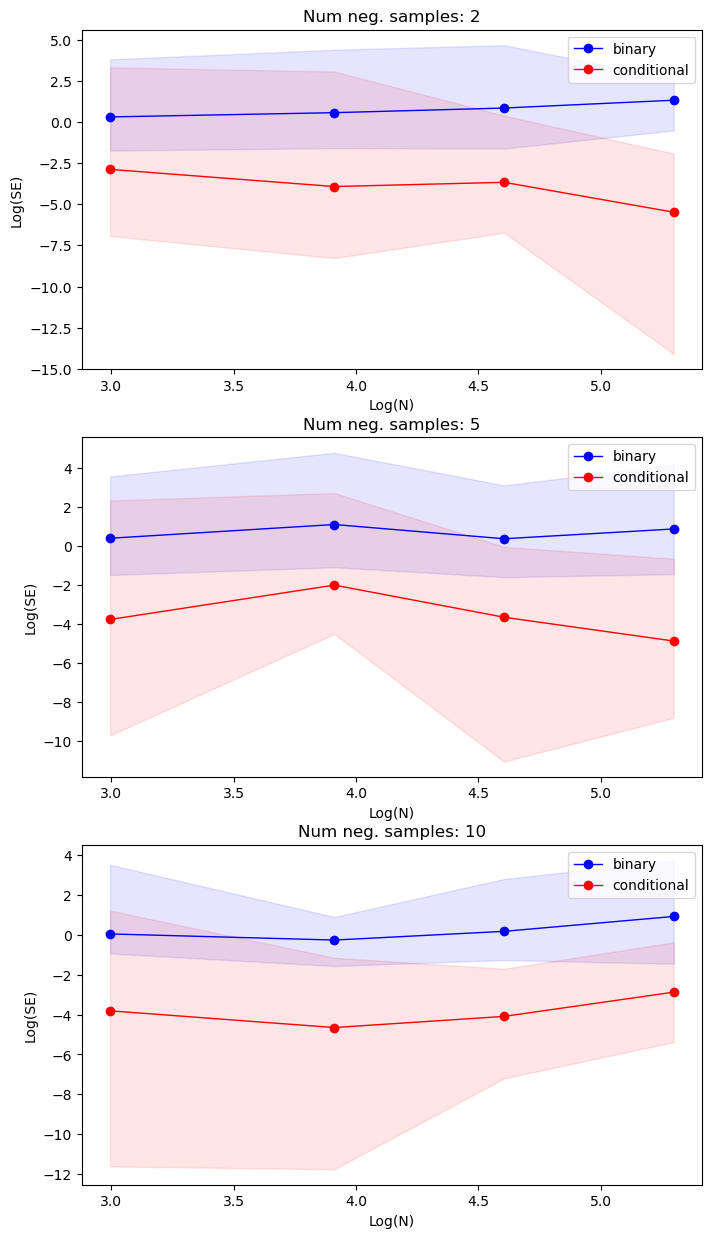

In [86]:
# Visualise results

error_res = np.load("res/final_param_error_ring_model_all.npy")

fig, ax = plt.subplots(len(num_neg_samples), 1, figsize=(8, 15))
colors = ['b', 'r']

log_num_samples = np.log(np.array(num_samples))
for j, axis in enumerate(ax):
    for k, (crit, lab) in enumerate(zip(criteria, crit_labels)):
        plot_res(log_num_samples, np.log(error_res[:, j, k, :]), lab, colors[k], axis)
        
    axis.set_title("Num neg. samples: {}".format(num_neg_samples[j]))    
    axis.set_xlabel("Log(N)")
    axis.set_ylabel("Log(SE)")
    axis.legend()
        
plt.show()